### Importación de todas la librerias utilizadas.

In [1]:
# Libreria para el manejo de excepciones en Python
import sys

#Libreria para el manejo de datos
import pandas as pd

# Librería propietaria utilitaria
import BayesLibUtils as blU

# Librería que contiene los modelos Bayesianos 
import ModelosLib as modelos

# Libreria para discretizar variables
from sklearn.preprocessing import KBinsDiscretizer

#Flag que permite visualizar o no las salidas de cada operación
outInfo = False

# Permite elegir con que modelo implementado realizar la Red Bayesiana
# "Python" == 0
# "R" == 1
flagModelo = 0

#Este flag solo está diseñado para operar cuando el valor "flagModelo == 1"
#True = permite usar el modelo con todas las variables discretas
#False = permite usar el modelo con variables mixtas, es decir, discretas y continuas
discreta = False 

#Este flag solo está diseñado para operar cuando el valor "flagModelo == 1"
#Permite indicar al aprendizaje de Estructura de "R" que algoritmo de puntuación utilizar
# Algoritmos de puntuación disponibles:
#   1. score = "aic"       -> Solo para variables discretas, es decir, cuando flag "discreta = True"
#   2. score = "bic"       -> Solo para variables discretas, es decir, cuando flag "discreta = True"
#   3. score = "loglik"    -> Solo para variables discretas, es decir, cuando flag "discreta = True"
#   4. score = "aic-cg"    -> Solo para variables mixtas, es decir, cuando flag "discreta = False"
#   5. score = "bic-cg"    -> Solo para variables mixtas, es decir, cuando flag "discreta = False"
#   6. score = "loglik-cg" -> Solo para variables mixtas, es decir, cuando flag "discreta = False"
scoreR = "aic-cg"

#Este flag solo está diseñado para operar cuando el valor "flagModelo == 0"
#Permite indicar al aprendizaje de Estructura de "Python que algoritmo de puntuación utilizar
# Algoritmos de puntuación disponibles:
#   1. score = "bic"  -> Bayesian Information Criterion (Tambien llamado MDL)
#   2. score = "k2"   -> 
#   3. score = "bdeu" -> (DB) Bayesian Dirichlet, (e) for likelihood-equivalence, (u) for uniform joint distibution
scorePython = 'k2'

#Este flag permite usar la base de datos balanceada o no 
#balanceado == True  -> usar datos balanceados
#balanceado == False -> usar datos desbalanceados
balanceado = False

#Este flag permite usar la selección de variables
#seleccionVariables > 0  -> Hace uso de la selección de variables
#La configuración permitida son valores multiplos de 5 partiendo en 5 y terminando en 20
seleccionVariables = 0

# variable que identifica que variable del modelo será usada como clase a analizar.
varClase = 'estado'

### Validación de parámetros para el funcionamiento del modelo

In [2]:
if flagModelo == 1:
    print("Validando parámetros para ejecución de modelo en R")
    if (discreta == True) & ((scoreR == "aic") | (scoreR == "bic") | (scoreR == "loglik")):
        print("Parámetros del modelo OK")
    elif (discreta == False) & ((scoreR == "aic-cg") | (scoreR == "bic-cg") | (scoreR == "loglik-cg")):
        print("Parámetros del modelo OK")
    else:
        sys.exit("Parámetros del modelo incorrectos, corrija el problema y vuelva a ejecutar")
else:
    print("Validando parámetros para ejecución de modelo en Python")
    if ((scorePython == "bic") | (scorePython == "k2") | (scorePython == "bdeu")):
        print("Parámetros del modelo OK")
    else:
        sys.exit("Parámetros del modelo incorrectos, corrija el problema y vuelva a ejecutar")

Validando parámetros para ejecución de modelo en Python
Parámetros del modelo OK


### Abriendo el conjunto de datos desde un archivo CSV y asignandolo al objeto DataFrame "df"

In [3]:
df = pd.read_csv('dataset_a.csv', sep=';', error_bad_lines=False)

## Transformación de variables cualitativas a continuas

### Etapas de la transformación

1. Se realiza la normalización de la variable "programa", que corresponde a una variable del tipo cualitativa/nominal.  También, se realiza la normalización de la variables "estado", que corresponde a una variable del tipo cualitativa/binaria.

2. Se realiza el reemplazo de los datos de las variables "programa" y "estado", utilizando la nornalización obtenida en la etapa anterior.  Con este reemplazo de datos las variables pasan a ser cuantitativas/continuas

3. Una vez que las variables mutaron, los datos quedan como tipo Object, por lo tanto se realiza un cast a int32 para ser usados.

In [4]:
#Etapa 1
normalizePrograma = df['programa'].value_counts(normalize=True, ascending=True)*100
if outInfo == True: 
    print('Pre-Normalización de variable "programa"')
    print('=======================================')
    print(normalizePrograma)
    print('\n')

normalizeEstado = df['estado'].value_counts(normalize=True, ascending=False)*100
if outInfo == True: 
    print('Pre-Normalización de variable "estado"')
    print('=====================================')
    print(normalizeEstado)
    print('\n')

#Etapa 2
for i in range(len(normalizePrograma)):
    df["programa"] = df["programa"].str.replace(normalizePrograma.index[i], str(i+1))

for i in range(len(normalizeEstado)):
    df["estado"] = df["estado"].str.replace(normalizeEstado.index[i], str(i))    

#Etapa 3
df['programa'] = df['programa'].astype('int')
df['estado'] = df['estado'].astype('int')

#Verificando que la transformación no haya afectado la normalización original
if outInfo == True:
    normalizePrograma = df['programa'].value_counts(normalize=True, ascending=True)*100
    print('Post-Normalización de variable "programa"')
    print('========================================')
    print(normalizePrograma)
    print('\n')

    normalizeEstado = df['estado'].value_counts(normalize=True, ascending=False)*100
    print('Post-Normalización de variable "estado"')
    print('======================================')
    print(normalizeEstado)

## Limpieza de variables

Se limpia el dataframe dejando solo las variables relevantes que, dado un estudio previo de la información, se determinó que eran relevantes y entregan un aporte real al modelo.

In [5]:
df = df.loc[:, ['lt', 'tt', 'pt', 'game_score', 
                'op1','op2', 'op3', 'op4', 'op5', 'op6',
                'sv1','sv2','sv3','sv4','sv5','sv6',
                'score', 'score_a', 'score_p', 'score_d', 'score_s',
                'programa', 'sol1', 'estado']]

if outInfo == True: print(df.columns)

## Discretizando variables cualitativas

Proporciona una forma de dividir características continuas en valores discretos.  La estrategia utilizada ("kmeans") 
permite elegir los "centroides" por cada "bins" establecido asignando cada muestra a su centroide más cercano, repitiendo el proceso hasta llegar a un umbral, es decir, se repite hasta que los centroides no se mueven significativamente.

En esta etapa se discretizaron las variables "lt", "tt", "pt", "game_score", "sol1".
Los "bins" fueron calculados a partir del metodo "bayesian_blocks" de la librería "astropy" que calcula la segmentación óptima de datos con los bloques bayesianos descritos por Scargle (2012).

K-means: https://scikit-learn.org/stable/modules/clustering.html#k-means

bloques bayesianos: https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S/abstract

In [6]:
if outInfo == True: 
    print('Pre-Discretización de variables')
    print('===============================')
    print(df.loc[:, ['lt', 'tt', 'pt', 'game_score', 'sol1']])
    print("\n")

# Obteniendo un "bins" optimo
bins = blU.bayesBlock(df["lt"])
if outInfo == True:    
    print("variable lt")
    print("===========")
    print("min : "+str(df["lt"].min()))
    print("max : "+str(df["lt"].max()))
    print("sum : "+str(df["lt"].sum()))
    print("bins: "+str(bins))
    print("\n")
valorDiscreto = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy = "kmeans").fit_transform(df[['lt']])
df[['lt']] = valorDiscreto

# Obteniendo un "bins" optimo
bins = blU.bayesBlock(df["tt"])
if outInfo == True: 
    print("variable tt")
    print("===========")
    print("min : "+str(df["tt"].min()))
    print("max : "+str(df["tt"].max()))
    print("sum : "+str(df["tt"].sum()))
    print("bins: "+str(bins))
    print("\n")
valorDiscreto = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy = "kmeans").fit_transform(df[['tt']])
df[['tt']] = valorDiscreto

# Obteniendo un "bins" optimo
bins = blU.bayesBlock(df["pt"])
if outInfo == True: 
    print("variable pt")
    print("===========")
    print("min : "+str(df["pt"].min()))
    print("max : "+str(df["pt"].max()))
    print("sum : "+str(df["pt"].sum()))
    print("bins: "+str(bins))
    print("\n")
valorDiscreto =  KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy = "kmeans").fit_transform(df[['pt']])
df[['pt']] = valorDiscreto

# Obteniendo un "bins" optimo
bins = blU.bayesBlock(df["game_score"])
if outInfo == True: 
    print("variable game_score")
    print("===========")
    print("min : "+str(df["game_score"].min()))
    print("max : "+str(df["game_score"].max()))
    print("sum : "+str(df["game_score"].sum()))
    print("bins: "+str(bins))
    print("\n")
valorDiscreto =  KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy = "kmeans").fit_transform(df[['game_score']])
df[['game_score']] = valorDiscreto

# Obteniendo un "bins" optimo
bins = blU.bayesBlock(df["sol1"])
if outInfo == True: 
    print("variable sol1")
    print("===========")
    print("min : "+str(df["sol1"].min()))
    print("max : "+str(df["sol1"].max()))
    print("sum : "+str(df["sol1"].sum()))
    print("bins: "+str(bins))
    print("\n")
valorDiscreto =  KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy = "kmeans").fit_transform(df[['sol1']])
df[['sol1']] = valorDiscreto

if outInfo == True: 
    print('Post-Discretización de variables')
    print('===============================')
    print(df.loc[:, ['lt', 'tt', 'pt', 'game_score', 'sol1']])

## Ejecución de modelos de red bayesiana

Ejecución de modelos de red bayesiana que permiten obtener la causalidad Bayesiana por medio de la libreria "bnlearn", tanto de Python como de R

INICIO DE SECCION DE ENTRENAMIENTO, FOLD:  1
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]


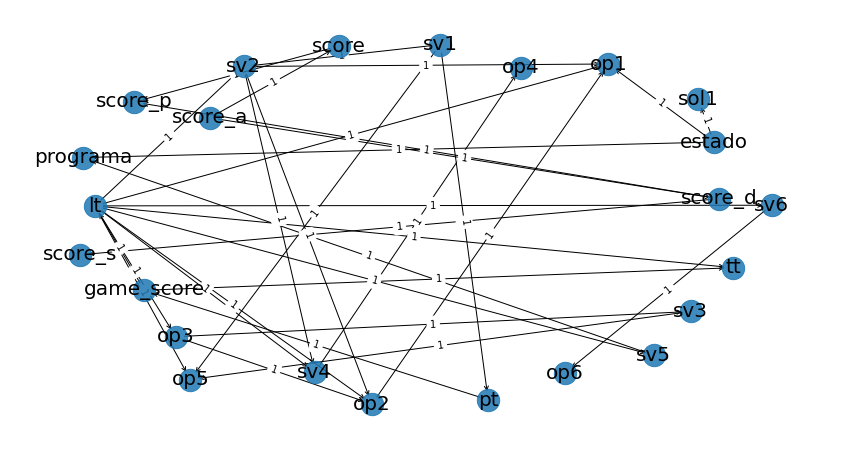

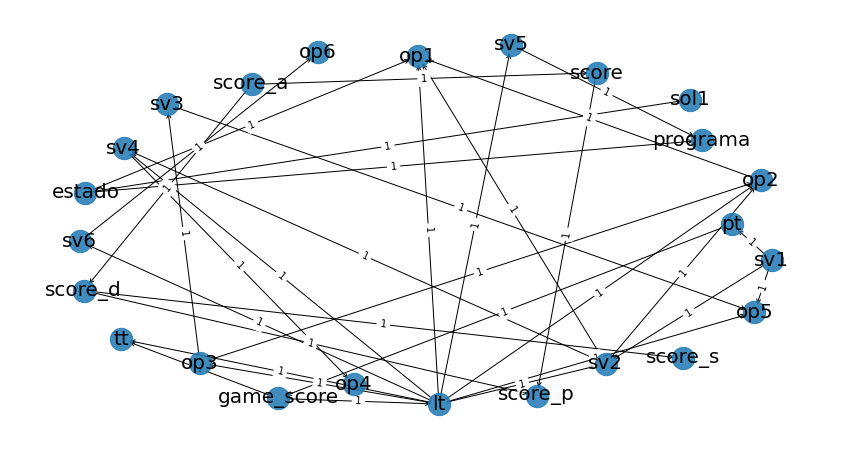

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

FILA N°: 1 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3181 |
+-----------+---------------+
| estado(1) |        0.6819 |
+-----------+---------------+
FILA N°: 2 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6345 |
+-----------+---------------+
| estado(1) |        0


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3272 |
+-----------+---------------+
| estado(1) |        0.6728 |
+-----------+---------------+
FILA N°: 4 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5156 |
+-----------+---------------+
| estado(1) |        0.4844 |
+-----------+---------------+
FILA N°: 7 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1":0.

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4128 |
+-----------+---------------+
| estado(1) |        0.5872 |
+-----------+---------------+
FILA N°: 8 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":1, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5464 |
+-----------+---------------+
| estado(1) |        0.4536 |
+-----------+---------------+
FILA N°: 9 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1":4.


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6438 |
+-----------+---------------+
| estado(1) |        0.3562 |
+-----------+---------------+
FILA N°: 10 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5906 |
+-----------+---------------+
| estado(1) |        0.4094 |
+-----------+---------------+
FILA N°: 11 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.2486 |
+-----------+---------------+
| estado(1) |        0.7514 |
+-----------+---------------+
FILA N°: 12 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6104 |
+-----------+---------------+
| estado(1) |        0.3896 |
+-----------+---------------+
FILA N°: 13 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6309 |
+-----------+---------------+
| estado(1) |        0.3691 |
+-----------+---------------+
FILA N°: 14 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3636 |
+-----------+---------------+
| estado(1) |        0.6364 |
+-----------+---------------+
FILA N°: 15 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3508 |
+-----------+---------------+
| estado(1) |        0.6492 |
+-----------+---------------+
FILA N°: 16 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5149 |
+-----------+---------------+
| estado(1) |        0.4851 |
+-----------+---------------+
FILA N°: 17 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":0, "programa":3, "sol1":



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


FILA N°: 18 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3508 |
+-----------+---------------+
| estado(1) |        0.6492 |
+-----------+---------------+
FILA N°: 19 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3319 |
+-----------+---------------+
| estado(1) |       


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5325 |
+-----------+---------------+
| estado(1) |        0.4675 |
+-----------+---------------+
FILA N°: 21 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5906 |
+-----------+---------------+
| estado(1) |        0.4094 |
+-----------+---------------+
FILA N°: 22 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1":2.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5325 |
+-----------+---------------+
| estado(1) |        0.4675 |
+-----------+---------------+
FILA N°: 23 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":3, "score_d":0, "score_s":1, "programa":4, "sol1":


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3472 |
+-----------+---------------+
| estado(1) |        0.6528 |
+-----------+---------------+
FILA N°: 24 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5357 |
+-----------+---------------+
| estado(1) |        0.4643 |
+-----------+---------------+
FILA N°: 25 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "programa":3, "sol1":


Finding Elimination Order: : : 0it [00:10, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5460 |
+-----------+---------------+
| estado(1) |        0.4540 |
+-----------+---------------+
FILA N°: 28 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 29 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [01:10, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3840 |
+-----------+---------------+
| estado(1) |        0.6160 |
+-----------+---------------+
FILA N°: 30 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6057 |
+-----------+---------------+
| estado(1) |        0.3943 |
+-----------+---------------+
FILA N°: 31 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1"

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5796 |
+-----------+---------------+
| estado(1) |        0.4204 |
+-----------+---------------+
FILA N°: 32 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7115 |
+-----------+---------------+
| estado(1) |        0.2885 |
+-----------+---------------+
FILA N°: 33 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1"

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7314 |
+-----------+---------------+
| estado(1) |        0.2686 |
+-----------+---------------+
FILA N°: 34 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5657 |
+-----------+---------------+
| estado(1) |        0.4343 |
+-----------+---------------+
FILA N°: 35 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4268 |
+-----------+---------------+
| estado(1) |        0.5732 |
+-----------+---------------+
FILA N°: 40 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6233 |
+-----------+---------------+
| estado(1) |        0.3767 |
+-----------+---------------+
FILA N°: 42 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4791 |
+-----------+---------------+
| estado(1) |        0.5209 |
+-----------+---------------+
FILA N°: 44 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":2, "programa":3, "sol1"

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:30, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6776 |
+-----------+---------------+
| estado(1) |        0.3224 |
+-----------+---------------+
FILA N°: 47 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":3, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4625 |
+-----------+---------------+
| estado(1) |        0.5375 |
+-----------+---------------+
FILA N°: 48 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6786 |
+-----------+---------------+
| estado(1) |        0.3214 |
+-----------+---------------+
FILA N°: 49 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5590 |
+-----------+---------------+
| estado(1) |        0.4410 |
+-----------+---------------+
FILA N°: 50 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:10, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6309 |
+-----------+---------------+
| estado(1) |        0.3691 |
+-----------+---------------+
FILA N°: 51 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":2, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3849 |
+-----------+---------------+
| estado(1) |        0.6151 |
+-----------+---------------+
FILA N°: 52 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":3, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6591 |
+-----------+---------------+
| estado(1) |        0.3409 |
+-----------+---------------+
FILA N°: 55 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5832 |
+-----------+---------------+
| estado(1) |        0.4168 |
+-----------+---------------+
FILA N°: 57 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 58 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":

0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]










+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5734 |
+-----------+---------------+
| estado(1) |        0.4266 |
+-----------+---------------+
FILA N°: 59 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":4, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6192 |
+-----------+---------------+
| estado(1) |        0.3808 |
+-----------+---------------+
FILA N°: 60 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]











+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6933 |
+-----------+---------------+
| estado(1) |        0.3067 |
+-----------+---------------+
FILA N°: 62 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5590 |
+-----------+---------------+
| estado(1) |        0.4410 |
+-----------+---------------+
FILA N°: 63 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":

0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7639 |
+-----------+---------------+
| estado(1) |        0.2361 |
+-----------+---------------+
FILA N°: 65 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7486 |
+-----------+---------------+
| estado(1) |        0.2514 |
+-----------+---------------+
FILA N°: 67 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":









0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7348 |
+-----------+---------------+
| estado(1) |        0.2652 |
+-----------+---------------+
FILA N°: 68 -> P("estado" | [{"lt":6.0, "tt":5.0, "pt":6.0, "game_score":5.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6323 |
+-----------+---------------+
| estado(1) |        0.3677 |
+-----------+---------------+
FILA N°: 69 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1"











0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7486 |
+-----------+---------------+
| estado(1) |        0.2514 |
+-----------+---------------+
FILA N°: 70 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5464 |
+-----------+---------------+
| estado(1) |        0.4536 |
+-----------+---------------+
FILA N°: 71 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8337 |
+-----------+---------------+
| estado(1) |        0.1663 |
+-----------+---------------+
FILA N°: 74 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7238 |
+-----------+---------------+
| estado(1) |        0.2762 |
+-----------+---------------+
FILA N°: 75 -> P("estado" | [{"lt":5.0, "tt":0.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5470 |
+-----------+---------------+
| estado(1) |        0.4530 |
+-----------+---------------+
FILA N°: 76 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":











0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7813 |
+-----------+---------------+
| estado(1) |        0.2187 |
+-----------+---------------+
FILA N°: 77 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5826 |
+-----------+---------------+
| estado(1) |        0.4174 |
+-----------+---------------+
FILA N°: 78 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]














+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6309 |
+-----------+---------------+
| estado(1) |        0.3691 |
+-----------+---------------+
FILA N°: 79 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6537 |
+-----------+---------------+
| estado(1) |        0.3463 |
+-----------+---------------+
FILA N°: 80 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":

0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6452 |
+-----------+---------------+
| estado(1) |        0.3548 |
+-----------+---------------+
FILA N°: 81 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7639 |
+-----------+---------------+
| estado(1) |        0.2361 |
+-----------+---------------+
FILA N°: 82 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":

0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:20, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6482 |
+-----------+---------------+
| estado(1) |        0.3518 |
+-----------+---------------+
FILA N°: 84 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8303 |
+-----------+---------------+
| estado(1) |        0.1697 |
+-----------+---------------+
FILA N°: 85 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":4, "sol1"













0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 86 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7380 |
+-----------+---------------+
| estado(1) |        0.2620 |
+-----------+---------------+
FILA N°: 87 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":















0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5413 |
+-----------+---------------+
| estado(1) |        0.4587 |
+-----------+---------------+
FILA N°: 89 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7571 |
+-----------+---------------+
| estado(1) |        0.2429 |
+-----------+---------------+
FILA N°: 91 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":0, "score_d":1, "score_s":1, "programa":5, "sol1":
















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7639 |
+-----------+---------------+
| estado(1) |        0.2361 |
+-----------+---------------+
FILA N°: 94 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7020 |
+-----------+---------------+
| estado(1) |        0.2980 |
+-----------+---------------+
FILA N°: 95 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":















0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6626 |
+-----------+---------------+
| estado(1) |        0.3374 |
+-----------+---------------+
FILA N°: 96 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8396 |
+-----------+---------------+
| estado(1) |        0.1604 |
+-----------+---------------+
FILA N°: 98 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6905 |
+-----------+---------------+
| estado(1) |        0.3095 |
+-----------+---------------+
FILA N°: 99 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 100 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1"


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 102 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 103 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 104 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7223 |
+-----------+---------------+
| estado(1) |        0.2777 |
+-----------+---------------+
FILA N°: 105 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1



















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7639 |
+-----------+---------------+
| estado(1) |        0.2361 |
+-----------+---------------+
FILA N°: 106 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7813 |
+-----------+---------------+
| estado(1) |        0.2187 |
+-----------+---------------+
FILA N°: 107 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7888 |
+-----------+---------------+
| estado(1) |        0.2112 |
+-----------+---------------+
FILA N°: 110 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 111 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol







































Finding Elimination Order: : : 0it [00:00, ?it/s][A
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7215 |
+-----------+---------------+
| estado(1) |        0.2785 |
+-----------+---------------+
FILA N°: 113 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7451 |
+-----------+---------------+
| estado(1) |        0.2549 |
+-----------+---------------+
FILA N°: 114 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 115 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6314 |
+-----------+---------------+
| estado(1) |        0.3686 |
+-----------+---------------+
FILA N°: 116 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7956 |
+-----------+---------------+
| estado(1) |        0.2044 |
+-----------+---------------+
FILA N°: 117 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 118 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5826 |
+-----------+---------------+
| estado(1) |        0.4174 |
+-----------+---------------+
FILA N°: 119 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 120 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1



















Finding Elimination Order: : : 0it [00:30, ?it/s][A


















Finding Elimination Order: : : 0it [01:10, ?it/s]



















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5796 |
+-----------+---------------+
| estado(1) |        0.4204 |
+-----------+---------------+
FILA N°: 121 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8413 |
+-----------+---------------+
| estado(1) |        0.1587 |
+-----------+---------------+
FILA N°: 122 -> P("estado" | [{"lt":4.0, "tt":4.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A



















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6960 |
+-----------+---------------+
| estado(1) |        0.3040 |
+-----------+---------------+
FILA N°: 123 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5796 |
+-----------+---------------+
| estado(1) |        0.4204 |
+-----------+---------------+
FILA N°: 124 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8830 |
+-----------+---------------+
| estado(1) |        0.1170 |
+-----------+---------------+
FILA N°: 125 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 126 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":4, "score_d":1, "score_s":0, "programa":1, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7536 |
+-----------+---------------+
| estado(1) |        0.2464 |
+-----------+---------------+
FILA N°: 127 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3636 |
+-----------+---------------+
| estado(1) |        0.6364 |
+-----------+---------------+
FILA N°: 128 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7613 |
+-----------+---------------+
| estado(1) |        0.2387 |
+-----------+---------------+
FILA N°: 130 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7130 |
+-----------+---------------+
| estado(1) |        0.2870 |
+-----------+---------------+
FILA N°: 131 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7746 |
+-----------+---------------+
| estado(1) |        0.2254 |
+-----------+---------------+
FILA N°: 132 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8195 |
+-----------+---------------+
| estado(1) |        0.1805 |
+-----------+---------------+
FILA N°: 133 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6905 |
+-----------+---------------+
| estado(1) |        0.3095 |
+-----------+---------------+
FILA N°: 134 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7639 |
+-----------+---------------+
| estado(1) |        0.2361 |
+-----------+---------------+
FILA N°: 135 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6233 |
+-----------+---------------+
| estado(1) |        0.3767 |
+-----------+---------------+
FILA N°: 136 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5413 |
+-----------+---------------+
| estado(1) |        0.4587 |
+-----------+---------------+
FILA N°: 137 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":7, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5902 |
+-----------+---------------+
| estado(1) |        0.4098 |
+-----------+---------------+
FILA N°: 139 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 141 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8281 |
+-----------+---------------+
| estado(1) |        0.1719 |
+-----------+---------------+
FILA N°: 142 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 143 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6438 |
+-----------+---------------+
| estado(1) |        0.3562 |
+-----------+---------------+
FILA N°: 144 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":0, "sv6":1, "score":1, "score_a":1, "score_p":0, "score_d":0, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7285 |
+-----------+---------------+
| estado(1) |        0.2715 |
+-----------+---------------+





















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


FILA N°: 145 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7925 |
+-----------+---------------+
| estado(1) |        0.2075 |
+-----------+---------------+
FILA N°: 146 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |    




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7921 |
+-----------+---------------+
| estado(1) |        0.2079 |
+-----------+---------------+
FILA N°: 150 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3840 |
+-----------+---------------+
| estado(1) |        0.6160 |
+-----------+---------------+
FILA N°: 151 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 152 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 153 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 154 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 155 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 157 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4487 |
+-----------+---------------+
| estado(1) |        0.5513 |
+-----------+---------------+
FILA N°: 160 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 161 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7344 |
+-----------+---------------+
| estado(1) |        0.2656 |
+-----------+---------------+
FILA N°: 162 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6166 |
+-----------+---------------+
| estado(1) |        0.3834 |
+-----------+---------------+
FILA N°: 163 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8235 |
+-----------+---------------+
| estado(1) |        0.1765 |
+-----------+---------------+
FILA N°: 164 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7020 |
+-----------+---------------+
| estado(1) |        0.2980 |
+-----------+---------------+
FILA N°: 167 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7276 |
+-----------+---------------+
| estado(1) |        0.2724 |
+-----------+---------------+
FILA N°: 168 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":2, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [25:32, ?it/s]
Finding Elimination Order: : : 0it [24:32, ?it/s]
Finding Elimination Order: : : 0it [22:41, ?it/s]
Finding Elimination Order: : : 0it [21:51, ?it/s]
Finding Elimination Order: : : 0it [19:31, ?it/s]
Finding Elimination Order: : : 0it [18:50, ?it/s]
Finding Elimination Order: : : 0it [16:50, ?it/s]
Finding Elimination Order: : : 0it [14:59, ?it/s]
Finding Elimination Order: : : 0it [14:09, ?it/s]
Finding Elimination Order: : : 0it [11:58, ?it/s]
Finding Elimination Order: : : 0it [11:18, ?it/s]
Finding Elimination Order: : : 0it [09:37, ?it/s]
Finding Elimination Order: : : 0it [08:37, ?it/s]
Finding Elimination Order: : : 0it [06:57, ?it/s]
Finding Elimination Order: : : 0it [06:06, ?it/s]
Finding Elimination Order: : :

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6674 |
+-----------+---------------+
| estado(1) |        0.3326 |
+-----------+---------------+
FILA N°: 169 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 170 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7641 |
+-----------+---------------+
| estado(1) |        0.2359 |
+-----------+---------------+
FILA N°: 171 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7414 |
+-----------+---------------+
| estado(1) |        0.2586 |
+-----------+---------------+
FILA N°: 172 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7463 |
+-----------+---------------+
| estado(1) |        0.2537 |
+-----------+---------------+
FILA N°: 173 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 174 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7639 |
+-----------+---------------+
| estado(1) |        0.2361 |
+-----------+---------------+
FILA N°: 175 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":4, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 176 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 178 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":4, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6978 |
+-----------+---------------+
| estado(1) |        0.3022 |
+-----------+---------------+
FILA N°: 179 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5056 |
+-----------+---------------+
| estado(1) |        0.4944 |
+-----------+---------------+
FILA N°: 180 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8281 |
+-----------+---------------+
| estado(1) |        0.1719 |
+-----------+---------------+
FILA N°: 181 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8281 |
+-----------+---------------+
| estado(1) |        0.1719 |
+-----------+---------------+
FILA N°: 182 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 183 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7919 |
+-----------+---------------+
| estado(1) |        0.2081 |
+-----------+---------------+
FILA N°: 184 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6969 |
+-----------+---------------+
| estado(1) |        0.3031 |
+-----------+---------------+
FILA N°: 188 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":4, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 190 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:10, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6362 |
+-----------+---------------+
| estado(1) |        0.3638 |
+-----------+---------------+
FILA N°: 191 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":6, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7662 |
+-----------+---------------+
| estado(1) |        0.2338 |
+-----------+---------------+
FILA N°: 192 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [01:10, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5413 |
+-----------+---------------+
| estado(1) |        0.4587 |
+-----------+---------------+
FILA N°: 193 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5464 |
+-----------+---------------+
| estado(1) |        0.4536 |
+-----------+---------------+
FILA N°: 194 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":2, "programa":2, "sol1


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]





+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5906 |
+-----------+---------------+
| estado(1) |        0.4094 |
+-----------+---------------+
FILA N°: 195 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8434 |
+-----------+---------------+
| estado(1) |        0.1566 |
+-----------+---------------+
FILA N°: 196 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so

0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8701 |
+-----------+---------------+
| estado(1) |        0.1299 |
+-----------+---------------+
FILA N°: 197 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":1, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 198 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":5, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8538 |
+-----------+---------------+
| estado(1) |        0.1462 |
+-----------+---------------+
FILA N°: 202 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6108 |
+-----------+---------------+
| estado(1) |        0.3892 |
+-----------+---------------+
FILA N°: 204 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5056 |
+-----------+---------------+
| estado(1) |        0.4944 |
+-----------+---------------+
FILA N°: 205 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":5.0, "game_score":4.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5151 |
+-----------+---------------+
| estado(1) |        0.4849 |
+-----------+---------------+
FILA N°: 207 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":2, "sol1






0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6718 |
+-----------+---------------+
| estado(1) |        0.3282 |
+-----------+---------------+
FILA N°: 209 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8504 |
+-----------+---------------+
| estado(1) |        0.1496 |
+-----------+---------------+
FILA N°: 210 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":4, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 212 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 213 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8504 |
+-----------+---------------+
| estado(1) |        0.1496 |
+-----------+---------------+
FILA N°: 214 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1






0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 215 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7915 |
+-----------+---------------+
| estado(1) |        0.2085 |
+-----------+---------------+
FILA N°: 217 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":2, "sol1







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6674 |
+-----------+---------------+
| estado(1) |        0.3326 |
+-----------+---------------+
FILA N°: 219 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":1, "score_p":3, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8054 |
+-----------+---------------+
| estado(1) |        0.1946 |
+-----------+---------------+
FILA N°: 220 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":2, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8451 |
+-----------+---------------+
| estado(1) |        0.1549 |
+-----------+---------------+
FILA N°: 223 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 224 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]










+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7130 |
+-----------+---------------+
| estado(1) |        0.2870 |
+-----------+---------------+
FILA N°: 225 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":1, "score_a":1, "score_p":1, "score_d":0, "score_s":0, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6626 |
+-----------+---------------+
| estado(1) |        0.3374 |
+-----------+---------------+
FILA N°: 226 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8265 |
+-----------+---------------+
| estado(1) |        0.1735 |
+-----------+---------------+
FILA N°: 227 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8830 |
+-----------+---------------+
| estado(1) |        0.1170 |
+-----------+---------------+
FILA N°: 228 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1







Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 229 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7603 |
+-----------+---------------+
| estado(1) |        0.2397 |
+-----------+---------------+
FILA N°: 230 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol








0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7662 |
+-----------+---------------+
| estado(1) |        0.2338 |
+-----------+---------------+
FILA N°: 231 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8413 |
+-----------+---------------+
| estado(1) |        0.1587 |
+-----------+---------------+
FILA N°: 232 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1








0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8075 |
+-----------+---------------+
| estado(1) |        0.1925 |
+-----------+---------------+
FILA N°: 233 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 234 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol

0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7662 |
+-----------+---------------+
| estado(1) |        0.2338 |
+-----------+---------------+
FILA N°: 235 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8396 |
+-----------+---------------+
| estado(1) |        0.1604 |
+-----------+---------------+
FILA N°: 236 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 238 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7915 |
+-----------+---------------+
| estado(1) |        0.2085 |
+-----------+---------------+
FILA N°: 239 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1

0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]








+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7627 |
+-----------+---------------+
| estado(1) |        0.2373 |
+-----------+---------------+
FILA N°: 240 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":0, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6438 |
+-----------+---------------+
| estado(1) |        0.3562 |
+-----------+---------------+
FILA N°: 241 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1

0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8054 |
+-----------+---------------+
| estado(1) |        0.1946 |
+-----------+---------------+
FILA N°: 242 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6674 |
+-----------+---------------+
| estado(1) |        0.3326 |
+-----------+---------------+
FILA N°: 244 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1








0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7159 |
+-----------+---------------+
| estado(1) |        0.2841 |
+-----------+---------------+
FILA N°: 248 -> P("estado" | [{"lt":4.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":3, "score_d":3, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7550 |
+-----------+---------------+
| estado(1) |        0.2450 |
+-----------+---------------+
FILA N°: 250 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 251 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7475 |
+-----------+---------------+
| estado(1) |        0.2525 |
+-----------+---------------+
FILA N°: 252 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8690 |
+-----------+---------------+
| estado(1) |        0.1310 |
+-----------+---------------+
FILA N°: 253 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 254 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1







Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8796 |
+-----------+---------------+
| estado(1) |        0.1204 |
+-----------+---------------+
FILA N°: 255 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4803 |
+-----------+---------------+
| estado(1) |        0.5197 |
+-----------+---------------+
FILA N°: 256 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7380 |
+-----------+---------------+
| estado(1) |        0.2620 |
+-----------+---------------+
FILA N°: 258 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7746 |
+-----------+---------------+
| estado(1) |        0.2254 |
+-----------+---------------+
FILA N°: 259 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":2, "sol1

0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3088 |
+-----------+---------------+
| estado(1) |        0.6912 |
+-----------+---------------+
FILA N°: 260 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7468 |
+-----------+---------------+
| estado(1) |        0.2532 |
+-----------+---------------+
FILA N°: 262 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":3, "programa":2, "sol







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6877 |
+-----------+---------------+
| estado(1) |        0.3123 |
+-----------+---------------+
FILA N°: 263 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7411 |
+-----------+---------------+
| estado(1) |        0.2589 |
+-----------+---------------+
FILA N°: 264 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]

FILA N°: 265 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8396 |
+-----------+---------------+
| estado(1) |        0.1604 |
+-----------+---------------+
FILA N°: 266 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7941 |
+-----------+---------------+
| estado(1) |     









0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6626 |
+-----------+---------------+
| estado(1) |        0.3374 |
+-----------+---------------+
FILA N°: 268 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7238 |
+-----------+---------------+
| estado(1) |        0.2762 |
+-----------+---------------+
FILA N°: 269 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7022 |
+-----------+---------------+
| estado(1) |        0.2978 |
+-----------+---------------+
FILA N°: 270 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5464 |
+-----------+---------------+
| estado(1) |        0.4536 |
+-----------+---------------+
FILA N°: 272 -> P("estado" | [{"lt":6.0, "tt":0.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7026 |
+-----------+---------------+
| estado(1) |        0.2974 |
+-----------+---------------+
FILA N°: 273 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 274 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1








Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8092 |
+-----------+---------------+
| estado(1) |        0.1908 |
+-----------+---------------+
FILA N°: 275 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7223 |
+-----------+---------------+
| estado(1) |        0.2777 |
+-----------+---------------+
FILA N°: 276 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6165 |
+-----------+---------------+
| estado(1) |        0.3835 |
+-----------+---------------+
FILA N°: 278 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7746 |
+-----------+---------------+
| estado(1) |        0.2254 |
+-----------+---------------+
FILA N°: 279 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7308 |
+-----------+---------------+
| estado(1) |        0.2692 |
+-----------+---------------+
FILA N°: 280 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7662 |
+-----------+---------------+
| estado(1) |        0.2338 |
+-----------+---------------+
FILA N°: 281 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 282 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6362 |
+-----------+---------------+
| estado(1) |        0.3638 |
+-----------+---------------+
FILA N°: 283 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5897 |
+-----------+---------------+
| estado(1) |        0.4103 |
+-----------+---------------+
FILA N°: 285 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6309 |
+-----------+---------------+
| estado(1) |        0.3691 |
+-----------+---------------+
FILA N°: 286 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol


Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5796 |
+-----------+---------------+
| estado(1) |        0.4204 |
+-----------+---------------+
FILA N°: 287 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7697 |
+-----------+---------------+
| estado(1) |        0.2303 |
+-----------+---------------+
FILA N°: 288 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":4.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":0, "score_p":2, "score_d":1, "score_s":1, "programa":5, "sol1







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8369 |
+-----------+---------------+
| estado(1) |        0.1631 |
+-----------+---------------+
FILA N°: 289 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6905 |
+-----------+---------------+
| estado(1) |        0.3095 |
+-----------+---------------+
FILA N°: 290 -> P("estado" | [{"lt":2.0, "tt":5.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8661 |
+-----------+---------------+
| estado(1) |        0.1339 |
+-----------+---------------+
FILA N°: 291 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 292 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1








0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8204 |
+-----------+---------------+
| estado(1) |        0.1796 |
+-----------+---------------+
FILA N°: 293 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 294 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 295 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7303 |
+-----------+---------------+
| estado(1) |        0.2697 |
+-----------+---------------+
FILA N°: 297 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1










0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [01:00, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8434 |
+-----------+---------------+
| estado(1) |        0.1566 |
+-----------+---------------+
FILA N°: 298 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 299 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:50, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]












+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 300 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":6, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8447 |
+-----------+---------------+
| estado(1) |        0.1553 |
+-----------+---------------+
FILA N°: 302 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [01:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 303 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8860 |
+-----------+---------------+
| estado(1) |        0.1140 |
+-----------+---------------+
FILA N°: 304 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 305 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6636 |
+-----------+---------------+
| estado(1) |        0.3364 |
+-----------+---------------+
FILA N°: 306 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1







0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 307 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8830 |
+-----------+---------------+
| estado(1) |        0.1170 |
+-----------+---------------+
FILA N°: 308 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1







0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7854 |
+-----------+---------------+
| estado(1) |        0.2146 |
+-----------+---------------+
FILA N°: 310 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7201 |
+-----------+---------------+
| estado(1) |        0.2799 |
+-----------+---------------+
FILA N°: 311 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol

0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:20, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:50, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8504 |
+-----------+---------------+
| estado(1) |        0.1496 |
+-----------+---------------+
FILA N°: 312 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7908 |
+-----------+---------------+
| estado(1) |        0.2092 |
+-----------+---------------+
FILA N°: 313 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol


0it [00:10, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]

















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7888 |
+-----------+---------------+
| estado(1) |        0.2112 |
+-----------+---------------+
FILA N°: 314 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8439 |
+-----------+---------------+
| estado(1) |        0.1561 |
+-----------+---------------+
FILA N°: 317 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8152 |
+-----------+---------------+
| estado(1) |        0.1848 |
+-----------+---------------+
FILA N°: 320 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+


















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:10, ?it/s]





Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:10, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


FILA N°: 321 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7012 |
+-----------+---------------+
| estado(1) |        0.2988 |
+-----------+---------------+
FILA N°: 322 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |     


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:20, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7697 |
+-----------+---------------+
| estado(1) |        0.2303 |
+-----------+---------------+
FILA N°: 325 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":1, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7916 |
+-----------+---------------+
| estado(1) |        0.2084 |
+-----------+---------------+
FILA N°: 327 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1



















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:20, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 328 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 330 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:30, ?it/s]
0it [00:10, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 331 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8054 |
+-----------+---------------+
| estado(1) |        0.1946 |
+-----------+---------------+
FILA N°: 335 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol

 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:30, ?it/s]
0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 336 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":0, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6737 |
+-----------+---------------+
| estado(1) |        0.3263 |
+-----------+---------------+
FILA N°: 337 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 339 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":3, "score_s":4, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5149 |
+-----------+---------------+
| estado(1) |        0.4851 |
+-----------+---------------+
FILA N°: 340 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 341 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 343 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8160 |
+-----------+---------------+
| estado(1) |        0.1840 |
+-----------+---------------+
FILA N°: 344 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8092 |
+-----------+---------------+
| estado(1) |        0.1908 |
+-----------+---------------+
FILA N°: 345 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7972 |
+-----------+---------------+
| estado(1) |        0.2028 |
+-----------+---------------+
FILA N°: 347 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 348 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7919 |
+-----------+---------------+
| estado(1) |        0.2081 |
+-----------+---------------+
FILA N°: 349 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8390 |
+-----------+---------------+
| estado(1) |        0.1610 |
+-----------+---------------+
FILA N°: 350 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 351 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 352 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8802 |
+-----------+---------------+
| estado(1) |        0.1198 |
+-----------+---------------+
FILA N°: 353 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":4, "score_s":4, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 354 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 355 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7697 |
+-----------+---------------+
| estado(1) |        0.2303 |
+-----------+---------------+
FILA N°: 356 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1




















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 357 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 359 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":2, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6738 |
+-----------+---------------+
| estado(1) |        0.3262 |
+-----------+---------------+
FILA N°: 360 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7919 |
+-----------+---------------+
| estado(1) |        0.2081 |
+-----------+---------------+
FILA N°: 361 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol




















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...




















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7468 |
+-----------+---------------+
| estado(1) |        0.2532 |
+-----------+---------------+
FILA N°: 362 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7065 |
+-----------+---------------+
| estado(1) |        0.2935 |
+-----------+---------------+
FILA N°: 363 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7115 |
+-----------+---------------+
| estado(1) |        0.2885 |
+-----------+---------------+
FILA N°: 364 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8396 |
+-----------+---------------+
| estado(1) |        0.1604 |
+-----------+---------------+
FILA N°: 365 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 366 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8447 |
+-----------+---------------+
| estado(1) |        0.1553 |
+-----------+---------------+
FILA N°: 367 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":0, "score_s":1, "programa":3, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8303 |
+-----------+---------------+
| estado(1) |        0.1697 |
+-----------+---------------+
FILA N°: 368 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7373 |
+-----------+---------------+
| estado(1) |        0.2627 |
+-----------+---------------+
FILA N°: 369 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A



















Finding Elimination Order: : : 0it [01:20, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7701 |
+-----------+---------------+
| estado(1) |        0.2299 |
+-----------+---------------+
FILA N°: 371 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5912 |
+-----------+---------------+
| estado(1) |        0.4088 |
+-----------+---------------+
FILA N°: 372 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 373 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1

 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A



















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6452 |
+-----------+---------------+
| estado(1) |        0.3548 |
+-----------+---------------+
FILA N°: 374 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7888 |
+-----------+---------------+
| estado(1) |        0.2112 |
+-----------+---------------+
FILA N°: 375 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7254 |
+-----------+---------------+
| estado(1) |        0.2746 |
+-----------+---------------+
FILA N°: 376 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8447 |
+-----------+---------------+
| estado(1) |        0.1553 |
+-----------+---------------+
FILA N°: 377 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":2, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A



















Finding Elimination Order: : : 0it [01:40, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3851 |
+-----------+---------------+
| estado(1) |        0.6149 |
+-----------+---------------+
FILA N°: 378 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8267 |
+-----------+---------------+
| estado(1) |        0.1733 |
+-----------+---------------+
FILA N°: 379 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5590 |
+-----------+---------------+
| estado(1) |        0.4410 |
+-----------+---------------+
FILA N°: 381 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:30, ?it/s]
0it [00:10, ?it/s]    

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7603 |
+-----------+---------------+
| estado(1) |        0.2397 |
+-----------+---------------+
FILA N°: 382 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..






















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8267 |
+-----------+---------------+
| estado(1) |        0.1733 |
+-----------+---------------+
FILA N°: 383 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7972 |
+-----------+---------------+
| estado(1) |        0.2028 |
+-----------+---------------+
FILA N°: 384 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":1, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 385 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 386 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7486 |
+-----------+---------------+
| estado(1) |        0.2514 |
+-----------+---------------+
FILA N°: 387 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A
Finding Elimination Order: : : 0it [29:46, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [29:16, ?it/s]
Finding Elimination Order: : : 0it [27:35, ?it/s]
Finding Elimination Order: : : 0it [27:15, ?it/s]
Finding Elimination Order: : : 0it [25:44, ?it/s]

Finding Elimination Order: : : 0it [25:04, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [24:44, ?it/s]
Finding Elimination Order: : : 0it [23:28, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [23:28, ?it/s]
Finding Elimination Order: : : 0it [22:27, ?it/s]


Finding Elimination Order: : : 0it [22:27, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [22:17, ?it/s]
Finding Elimination Order: : : 0it [21:46, ?it/

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8343 |
+-----------+---------------+
| estado(1) |        0.1657 |
+-----------+---------------+
FILA N°: 388 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 390 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [11:20, ?it/s]
Finding Elimination Order: : : 0it [09:20, ?it/s]
Finding Elimination Order: : : 0it [07:20, ?it/s]
Finding Elimination Order: : : 0it [04:50, ?it/s]

Finding Elimination Order: : : 0it [02:50, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [01:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 396 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8232 |
+-----------+---------------+
| estado(1) |        0.1768 |
+-----------+---------------+
FILA N°: 400 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 405 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 406 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":3, "programa":4, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 407 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7697 |
+-----------+---------------+
| estado(1) |        0.2303 |
+-----------+---------------+
FILA N°: 408 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8021 |
+-----------+---------------+
| estado(1) |        0.1979 |
+-----------+---------------+
FILA N°: 411 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 412 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7667 |
+-----------+---------------+
| estado(1) |        0.2333 |
+-----------+---------------+
FILA N°: 413 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 414 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6905 |
+-----------+---------------+
| estado(1) |        0.3095 |
+-----------+---------------+
FILA N°: 415 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5903 |
+-----------+---------------+
| estado(1) |        0.4097 |
+-----------+---------------+
FILA N°: 416 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":4.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1



Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 417 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 418 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7854 |
+-----------+---------------+
| estado(1) |        0.2146 |
+-----------+---------------+
FILA N°: 419 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 420 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8802 |
+-----------+---------------+
| estado(1) |        0.1198 |
+-----------+---------------+
FILA N°: 422 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":4, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7887 |
+-----------+---------------+
| estado(1) |        0.2113 |
+-----------+---------------+
FILA N°: 423 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8439 |
+-----------+---------------+
| estado(1) |        0.1561 |
+-----------+---------------+
FILA N°: 424 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8661 |
+-----------+---------------+
| estado(1) |        0.1339 |
+-----------+---------------+
FILA N°: 425 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 426 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7854 |
+-----------+---------------+
| estado(1) |        0.2146 |
+-----------+---------------+
FILA N°: 427 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8796 |
+-----------+---------------+
| estado(1) |        0.1204 |
+-----------+---------------+
FILA N°: 428 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8152 |
+-----------+---------------+
| estado(1) |        0.1848 |
+-----------+---------------+
FILA N°: 429 -> P("estado" | [{"lt":4.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":1, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7735 |
+-----------+---------------+
| estado(1) |        0.2265 |
+-----------+---------------+
FILA N°: 430 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8092 |
+-----------+---------------+
| estado(1) |        0.1908 |
+-----------+---------------+
FILA N°: 431 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7933 |
+-----------+---------------+
| estado(1) |        0.2067 |
+-----------+---------------+
FILA N°: 432 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 434 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1



Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 435 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 436 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 437 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7729 |
+-----------+---------------+
| estado(1) |        0.2271 |
+-----------+---------------+
FILA N°: 438 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 439 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7950 |
+-----------+---------------+
| estado(1) |        0.2050 |
+-----------+---------------+
FILA N°: 440 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol



Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8434 |
+-----------+---------------+
| estado(1) |        0.1566 |
+-----------+---------------+
FILA N°: 441 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 443 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 444 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 445 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8439 |
+-----------+---------------+
| estado(1) |        0.1561 |
+-----------+---------------+
FILA N°: 446 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8439 |
+-----------+---------------+
| estado(1) |        0.1561 |
+-----------+---------------+
FILA N°: 447 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 448 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6938 |
+-----------+---------------+
| estado(1) |        0.3062 |
+-----------+---------------+
FILA N°: 450 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 453 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8830 |
+-----------+---------------+
| estado(1) |        0.1170 |
+-----------+---------------+
FILA N°: 454 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


FILA N°: 455 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 456 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |    

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]





FILA N°: 457 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7345 |
+-----------+---------------+
| estado(1) |        0.2655 |
+-----------+---------------+
FILA N°: 461 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 463 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7886 |
+-----------+---------------+
| estado(1) |        0.2114 |
+-----------+---------------+
FILA N°: 465 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8269 |
+-----------+---------------+
| estado(1) |        0.1731 |
+-----------+---------------+
FILA N°: 466 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8504 |
+-----------+---------------+
| estado(1) |        0.1496 |
+-----------+---------------+
[[326   8]
 [ 25  14]]
RESULTADOS DEL ENTRENAMIENTO:
(TRAIN) Fold 1 Accuracy          : 0.9115281501340483
(TRAIN) Fold 1 Balanced Accuracy : 0.7825692825692825
(TRAIN) Fold 1 Precision Score   : 0.9396521454924756
(TRAIN) Fold 1 Recall Score      : 0.9115281501340483



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5961 |
+-----------+---------------+
| estado(1) |        0.4039 |
+-----------+---------------+
FILA N°: 6 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5961 |
+-----------+---------------+
| estado(1) |        0.4039 |
+-----------+---------------+
FILA N°: 26 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":4

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4803 |
+-----------+---------------+
| estado(1) |        0.5197 |
+-----------+---------------+
FILA N°: 36 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7311 |
+-----------+---------------+
| estado(1) |        0.2689 |
+-----------+---------------+
FILA N°: 37 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1"




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7020 |
+-----------+---------------+
| estado(1) |        0.2980 |
+-----------+---------------+
FILA N°: 39 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 41 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1":

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6603 |
+-----------+---------------+
| estado(1) |        0.3397 |
+-----------+---------------+
FILA N°: 43 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6600 |
+-----------+---------------+
| estado(1) |        0.3400 |
+-----------+---------------+
FILA N°: 45 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":



Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4791 |
+-----------+---------------+
| estado(1) |        0.5209 |
+-----------+---------------+
FILA N°: 46 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8369 |
+-----------+---------------+
| estado(1) |        0.1631 |
+-----------+---------------+
FILA N°: 54 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7408 |
+-----------+---------------+
| estado(1) |        0.2592 |
+-----------+---------------+
FILA N°: 56 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3803 |
+-----------+---------------+
| estado(1) |        0.6197 |
+-----------+---------------+
FILA N°: 61 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":4, "programa":5, "sol1":

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8759 |
+-----------+---------------+
| estado(1) |        0.1241 |
+-----------+---------------+
FILA N°: 66 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8396 |
+-----------+---------------+
| estado(1) |        0.1604 |
+-----------+---------------+
FILA N°: 72 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7944 |
+-----------+---------------+
| estado(1) |        0.2056 |
+-----------+---------------+
FILA N°: 88 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6352 |
+-----------+---------------+
| estado(1) |        0.3648 |
+-----------+---------------+
FILA N°: 90 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3508 |
+-----------+---------------+
| estado(1) |        0.6492 |
+-----------+---------------+
FILA N°: 93 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 97 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 108 -> P("estado" | [{"lt":4.0, "tt":3.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8092 |
+-----------+---------------+
| estado(1) |        0.1908 |
+-----------+---------------+
FILA N°: 112 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 129 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 138 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8439 |
+-----------+---------------+
| estado(1) |        0.1561 |
+-----------+---------------+
FILA N°: 140 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7921 |
+-----------+---------------+
| estado(1) |        0.2079 |
+-----------+---------------+
FILA N°: 148 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":7, "score_p":1, "score_d":4, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5766 |
+-----------+---------------+
| estado(1) |        0.4234 |
+-----------+---------------+
FILA N°: 149 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6133 |
+-----------+---------------+
| estado(1) |        0.3867 |
+-----------+---------------+
FILA N°: 156 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8701 |
+-----------+---------------+
| estado(1) |        0.1299 |
+-----------+---------------+
FILA N°: 158 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7380 |
+-----------+---------------+
| estado(1) |        0.2620 |
+-----------+---------------+
FILA N°: 159 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7921 |
+-----------+---------------+
| estado(1) |        0.2079 |
+-----------+---------------+
FILA N°: 165 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8019 |
+-----------+---------------+
| estado(1) |        0.1981 |
+-----------+---------------+
FILA N°: 166 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1



Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7746 |
+-----------+---------------+
| estado(1) |        0.2254 |
+-----------+---------------+
FILA N°: 177 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7921 |
+-----------+---------------+
| estado(1) |        0.2079 |
+-----------+---------------+
FILA N°: 185 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7250 |
+-----------+---------------+
| estado(1) |        0.2750 |
+-----------+---------------+
FILA N°: 186 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6057 |
+-----------+---------------+
| estado(1) |        0.3943 |
+-----------+---------------+
FILA N°: 187 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "programa":4, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6626 |
+-----------+---------------+
| estado(1) |        0.3374 |
+-----------+---------------+
FILA N°: 189 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 200 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8092 |
+-----------+---------------+
| estado(1) |        0.1908 |
+-----------+---------------+
FILA N°: 201 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":0, "score_d":1, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7662 |
+-----------+---------------+
| estado(1) |        0.2338 |
+-----------+---------------+
FILA N°: 203 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":1, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5712 |
+-----------+---------------+
| estado(1) |        0.4288 |
+-----------+---------------+
FILA N°: 206 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 208 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6233 |
+-----------+---------------+
| estado(1) |        0.3767 |
+-----------+---------------+
FILA N°: 216 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":3, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6352 |
+-----------+---------------+
| estado(1) |        0.3648 |
+-----------+---------------+
FILA N°: 218 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7486 |
+-----------+---------------+
| estado(1) |        0.2514 |
+-----------+---------------+
FILA N°: 221 -> P("estado" | [{"lt":4.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 237 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":3, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6247 |
+-----------+---------------+
| estado(1) |        0.3753 |
+-----------+---------------+
FILA N°: 243 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6314 |
+-----------+---------------+
| estado(1) |        0.3686 |
+-----------+---------------+
FILA N°: 245 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4664 |
+-----------+---------------+
| estado(1) |        0.5336 |
+-----------+---------------+
FILA N°: 246 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8413 |
+-----------+---------------+
| estado(1) |        0.1587 |
+-----------+---------------+
FILA N°: 247 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5460 |
+-----------+---------------+
| estado(1) |        0.4540 |
+-----------+---------------+
FILA N°: 249 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8396 |
+-----------+---------------+
| estado(1) |        0.1604 |
+-----------+---------------+
FILA N°: 257 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]


FILA N°: 261 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5066 |
+-----------+---------------+
| estado(1) |        0.4934 |
+-----------+---------------+
FILA N°: 271 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..




Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8390 |
+-----------+---------------+
| estado(1) |        0.1610 |
+-----------+---------------+
FILA N°: 277 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 296 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 301 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8439 |
+-----------+---------------+
| estado(1) |        0.1561 |
+-----------+---------------+
FILA N°: 309 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7854 |
+-----------+---------------+
| estado(1) |        0.2146 |
+-----------+---------------+
FILA N°: 315 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 316 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7065 |
+-----------+---------------+
| estado(1) |        0.2935 |
+-----------+---------------+
FILA N°: 318 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7729 |
+-----------+---------------+
| estado(1) |        0.2271 |
+-----------+---------------+
FILA N°: 319 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":2, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6601 |
+-----------+---------------+
| estado(1) |        0.3399 |
+-----------+---------------+
FILA N°: 324 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7368 |
+-----------+---------------+
| estado(1) |        0.2632 |
+-----------+---------------+
FILA N°: 326 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":2, "score_d":1, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 329 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7303 |
+-----------+---------------+
| estado(1) |        0.2697 |
+-----------+---------------+
FILA N°: 332 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7025 |
+-----------+---------------+
| estado(1) |        0.2975 |
+-----------+---------------+
FILA N°: 333 -> P("estado" | [{"lt":5.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6846 |
+-----------+---------------+
| estado(1) |        0.3154 |
+-----------+---------------+
FILA N°: 334 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 338 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6713 |
+-----------+---------------+
| estado(1) |        0.3287 |
+-----------+---------------+
FILA N°: 342 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7606 |
+-----------+---------------+
| estado(1) |        0.2394 |
+-----------+---------------+
FILA N°: 346 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8240 |
+-----------+---------------+
| estado(1) |        0.1760 |
+-----------+---------------+
FILA N°: 358 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8187 |
+-----------+---------------+
| estado(1) |        0.1813 |
+-----------+---------------+
FILA N°: 370 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7311 |
+-----------+---------------+
| estado(1) |        0.2689 |
+-----------+---------------+
FILA N°: 380 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 389 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8728 |
+-----------+---------------+
| estado(1) |        0.1272 |
+-----------+---------------+
FILA N°: 394 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8374 |
+-----------+---------------+
| estado(1) |        0.1626 |
+-----------+---------------+
FILA N°: 397 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6722 |
+-----------+---------------+
| estado(1) |        0.3278 |
+-----------+---------------+
FILA N°: 398 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7854 |
+-----------+---------------+
| estado(1) |        0.2146 |
+-----------+---------------+
FILA N°: 399 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8269 |
+-----------+---------------+
| estado(1) |        0.1731 |
+-----------+---------------+
FILA N°: 402 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




FILA N°: 404 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7942 |
+-----------+---------------+
| estado(1) |        0.2058 |
+-----------+---------------+
FILA N°: 409 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":4, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6626 |
+-----------+---------------+
| estado(1) |        0.3374 |
+-----------+---------------+
FILA N°: 410 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8092 |
+-----------+---------------+
| estado(1) |        0.1908 |
+-----------+---------------+
FILA N°: 421 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8303 |
+-----------+---------------+
| estado(1) |        0.1697 |
+-----------+---------------+
FILA N°: 433 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8135 |
+-----------+---------------+
| estado(1) |        0.1865 |
+-----------+---------------+
FILA N°: 442 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 449 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 451 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8796 |
+-----------+---------------+
| estado(1) |        0.1204 |
+-----------+---------------+
FILA N°: 452 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8504 |
+-----------+---------------+
| estado(1) |        0.1496 |
+-----------+---------------+
FILA N°: 458 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8614 |
+-----------+---------------+
| estado(1) |        0.1386 |
+-----------+---------------+
FILA N°: 459 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.9095 |
+-----------+---------------+
| estado(1) |        0.0905 |
+-----------+---------------+
FILA N°: 460 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8390 |
+-----------+---------------+
| estado(1) |        0.1610 |
+-----------+---------------+
FILA N°: 462 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8776 |
+-----------+---------------+
| estado(1) |        0.1224 |
+-----------+---------------+
FILA N°: 464 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7391 |
+-----------+---------------+
| estado(1) |        0.2609 |
+-----------+---------------+
FILA N°: 467 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8796 |
+-----------+---------------+
| estado(1) |        0.1204 |
+-----------+---------------+
[[81  3]
 [ 8  2]]
RESULTADOS DEL ENTRENAMIENTO:
(TEST) Fold 1 Accuracy          : 0.8829787234042553
(TEST) Fold 1 Balanced Accuracy : 0.655056179775281
(TEST) Fold 1 Precision Score   : 0.9236322188449848
(TEST) Fold 1 Recall Score      : 0.8829787234042553
(TEST) F

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:15, ?it/s]


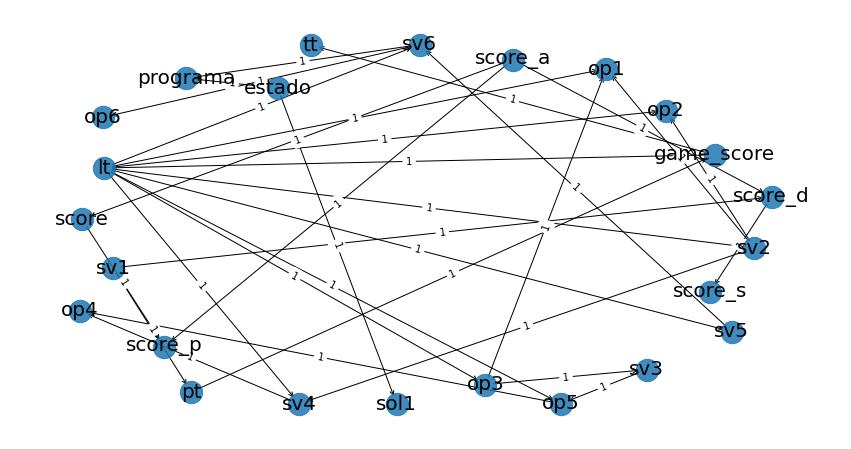

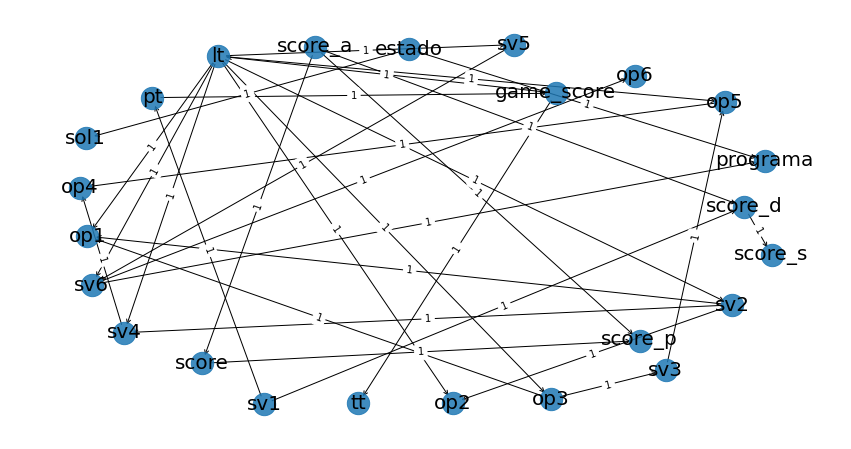

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

FILA N°: 1 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4592 |
+-----------+---------------+
| estado(1) |        0.5408 |
+-----------+---------------+
FILA N°: 2 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5730 |
+-----------+---------------+
| estado(1) |        0



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3493 |
+-----------+---------------+
| estado(1) |        0.6507 |
+-----------+---------------+
FILA N°: 4 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5730 |
+-----------+---------------+
| estado(1) |        0.4270 |
+-----------+---------------+
FILA N°: 5 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":0.

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4592 |
+-----------+---------------+
| estado(1) |        0.5408 |
+-----------+---------------+
FILA N°: 7 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4228 |
+-----------+---------------+
| estado(1) |        0.5772 |
+-----------+---------------+
FILA N°: 8 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":1, "programa":5, "sol1":6.

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 9 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5129 |
+-----------+---------------+
| estado(1) |        0.4871 |
+-----------+---------------+
FILA N°: 10 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":2, "sol1":6

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4051 |
+-----------+---------------+
| estado(1) |        0.5949 |
+-----------+---------------+
FILA N°: 12 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":4.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5685 |
+-----------+---------------+
| estado(1) |        0.4315 |
+-----------+---------------+
FILA N°: 13 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 14 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4816 |
+-----------+---------------+
| estado(1) |        0.5184 |
+-----------+---------------+
FILA N°: 17 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":0, "programa":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4228 |
+-----------+---------------+
| estado(1) |        0.5772 |
+-----------+---------------+
FILA N°: 18 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 19 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4604 |
+-----------+---------------+
| estado(1) |        0.5396 |
+-----------+---------------+
FILA N°: 23 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":3, "score_d":0, "score_s":1, "programa":4, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5010 |
+-----------+---------------+
| estado(1) |        0.4990 |
+-----------+---------------+
FILA N°: 24 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 25 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5740 |
+-----------+---------------+
| estado(1) |        0.4260 |
+-----------+---------------+
FILA N°: 26 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [03:01, ?it/s]
Finding Elimination Order: : : 0it [01:31, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 30 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5730 |
+-----------+---------------+
| estado(1) |        0.4270 |
+-----------+---------------+
FILA N°: 31 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 32 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 35 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":2, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6299 |
+-----------+---------------+
| estado(1) |        0.3701 |
+-----------+---------------+
FILA N°: 36 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6280 |
+-----------+---------------+
| estado(1) |        0.3720 |
+-----------+---------------+
FILA N°: 37 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 38 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 41 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 43 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5147 |
+-----------+---------------+
| estado(1) |        0.4853 |
+-----------+---------------+
FILA N°: 45 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 48 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 49 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 50 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5595 |
+-----------+---------------+
| estado(1) |        0.4405 |
+-----------+---------------+
FILA N°: 51 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6177 |
+-----------+---------------+
| estado(1) |        0.3823 |
+-----------+---------------+
FILA N°: 53 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 54 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 55 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 56 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5568 |
+-----------+---------------+
| estado(1) |        0.4432 |
+-----------+---------------+
FILA N°: 57 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:30, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5129 |
+-----------+---------------+
| estado(1) |        0.4871 |
+-----------+---------------+
FILA N°: 59 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":4, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 60 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5836 |
+-----------+---------------+
| estado(1) |        0.4164 |
+-----------+---------------+
FILA N°: 61 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":4, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 62 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 64 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 65 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 66 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":

0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 67 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 68 -> P("estado" | [{"lt":6.0, "tt":5.0, "pt":6.0, "game_score":5.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6424 |
+-----------+---------------+
| estado(1) |        0.3576 |
+-----------+---------------+
FILA N°: 69 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 71 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 72 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 75 -> P("estado" | [{"lt":5.0, "tt":0.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5595 |
+-----------+---------------+
| estado(1) |        0.4405 |
+-----------+---------------+
FILA N°: 76 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:50, ?it/s]


FILA N°: 77 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 78 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 79 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6299 |
+-----------+---------------+
| estado(1) |        0.3701 |
+-----------+---------------+
FILA N°: 83 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 85 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 86 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 88 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6643 |
+-----------+---------------+
| estado(1) |        0.3357 |
+-----------+---------------+
FILA N°: 89 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 90 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 92 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 93 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 95 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 96 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 97 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 100 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 101 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 102 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 104 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 105 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 108 -> P("estado" | [{"lt":4.0, "tt":3.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 111 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 112 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6247 |
+-----------+---------------+
| estado(1) |        0.3753 |
+-----------+---------------+
FILA N°: 114 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 116 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6660 |
+-----------+---------------+
| estado(1) |        0.3340 |
+-----------+---------------+
FILA N°: 118 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 120 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 121 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 122 -> P("estado" | [{"lt":4.0, "tt":4.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 124 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 125 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 127 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1
















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7317 |
+-----------+---------------+
| estado(1) |        0.2683 |
+-----------+---------------+
FILA N°: 129 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 130 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 132 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 133 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 134 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [01:00, ?it/s]



FILA N°: 135 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 136 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 137 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":7, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 138 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 139 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 141 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 142 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 143 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5129 |
+-----------+---------------+
| estado(1) |        0.4871 |
+-----------+---------------+
FILA N°: 144 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":0, "sv6":1, "score":1, "score_a":1, "score_p":0, "score_d":0, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 145 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 147 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6247 |
+-----------+---------------+
| estado(1) |        0.3753 |
+-----------+---------------+
FILA N°: 149 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 150 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 152 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 153 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 155 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


FILA N°: 156 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 157 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4816 |
+-----------+---------------+
| estado(1) |   





















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



FILA N°: 158 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 159 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..





















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 160 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 164 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol




















 ... (more hidden) ...



















Finding Elimination Order: : : 0it [19:40, ?it/s]
Finding Elimination Order: : : 0it [18:09, ?it/s]
Finding Elimination Order: : : 0it [16:48, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [16:28, ?it/s]
Finding Elimination Order: : : 0it [15:57, ?it/s]
Finding Elimination Order: : : 0it [15:47, ?it/s]
Finding Elimination Order: : : 0it [14:26, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [14:16, ?it/s]
Finding Elimination Order: : : 0it [13:15, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [13:45, ?it/s]
Finding Elimination Order: : : 0it [13:24, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [13:34, ?it/s]
Finding Elimination Order: : : 0it [13:03, ?it/s]



Finding Elimination Order: : : 0it [13:13, ?it/s]



Finding Elimination Order: : : 0it [13:03, ?it/s]




Finding Elimination Order: : : 0it [13:02, ?it/s]
Finding Elimination Order: : : 0it [12:12, ?i

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 165 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 166 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 173 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 175 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":4, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 176 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 177 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 179 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 181 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 182 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol

0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 185 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 186 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 188 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":4, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 189 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 190 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6280 |
+-----------+---------------+
| estado(1) |        0.3720 |
+-----------+---------------+
FILA N°: 191 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":6, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 194 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":2, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4604 |
+-----------+---------------+
| estado(1) |        0.5396 |
+-----------+---------------+
FILA N°: 195 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 196 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 197 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":1, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 198 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":5, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1






0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 200 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 201 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":0, "score_d":1, "score_s":1, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 203 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6141 |
+-----------+---------------+
| estado(1) |        0.3859 |
+-----------+---------------+
FILA N°: 205 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":5.0, "game_score":4.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5010 |
+-----------+---------------+
| estado(1) |        0.4990 |
+-----------+---------------+
FILA N°: 206 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 208 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 209 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 211 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 212 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 213 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 215 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 216 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":3, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6643 |
+-----------+---------------+
| estado(1) |        0.3357 |
+-----------+---------------+
FILA N°: 218 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 219 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":1, "score_p":3, "score_d":1, "score_s":1, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 220 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4604 |
+-----------+---------------+
| estado(1) |        0.5396 |
+-----------+---------------+
FILA N°: 221 -> P("estado" | [{"lt":4.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 222 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 224 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 225 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":1, "score_a":1, "score_p":1, "score_d":0, "score_s":0, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 226 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]











+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 227 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 228 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1

0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 229 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 230 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]











+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 235 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 236 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 237 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5913 |
+-----------+---------------+
| estado(1) |        0.4087 |
+-----------+---------------+
FILA N°: 238 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1











0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7317 |
+-----------+---------------+
| estado(1) |        0.2683 |
+-----------+---------------+
FILA N°: 243 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 245 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6299 |
+-----------+---------------+
| estado(1) |        0.3701 |
+-----------+---------------+
FILA N°: 246 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 247 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:20, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7317 |
+-----------+---------------+
| estado(1) |        0.2683 |
+-----------+---------------+
FILA N°: 249 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 250 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 252 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 253 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 254 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 255 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6247 |
+-----------+---------------+
| estado(1) |        0.3753 |
+-----------+---------------+
FILA N°: 256 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 258 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 259 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":2, "sol1":3.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4742 |
+-----------+---------------+
| estado(1) |        0.5258 |
+-----------+---------------+
FILA N°: 260 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 261 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 263 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 264 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 267 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "programa":4, "sol1















0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:30, ?it/s]



FILA N°: 268 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 269 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 270 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 273 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 274 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 275 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5891 |
+-----------+---------------+
| estado(1) |        0.4109 |
+-----------+---------------+
FILA N°: 277 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 279 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "so

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 280 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7317 |
+-----------+---------------+
| estado(1) |        0.2683 |
+-----------+---------------+
FILA N°: 281 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6280 |
+-----------+---------------+
| estado(1) |        0.3720 |
+-----------+---------------+
FILA N°: 284 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5938 |
+-----------+---------------+
| estado(1) |        0.4062 |
+-----------+---------------+
FILA N°: 285 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 286 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 287 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":4, "sol1



















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 289 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 290 -> P("estado" | [{"lt":2.0, "tt":5.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 291 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 293 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol




















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 294 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 296 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A


FILA N°: 297 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7539 |
+-----------+---------------+
| estado(1) |        0.2461 |
+-----------+---------------+
FILA N°: 298 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 300 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":6, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 301 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















                      

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 302 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 305 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 309 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 311 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1




















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 312 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 314 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 315 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 316 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":2, "programa":4, "sol1

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 319 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5938 |
+-----------+---------------+
| estado(1) |        0.4062 |
+-----------+---------------+
FILA N°: 321 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1





















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7317 |
+-----------+---------------+
| estado(1) |        0.2683 |
+-----------+---------------+
FILA N°: 322 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 323 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 324 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 325 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":1, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 326 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":2, "score_d":1, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 328 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 329 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 330 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 331 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 332 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 333 -> P("estado" | [{"lt":5.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6643 |
+-----------+---------------+
| estado(1) |        0.3357 |
+-----------+---------------+
FILA N°: 334 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 335 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 336 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":0, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 338 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6280 |
+-----------+---------------+
| estado(1) |        0.3720 |
+-----------+---------------+
FILA N°: 339 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":3, "score_s":4, "programa":3, "sol1




















 ... (more hidden) ...



















Finding Elimination Order: : : 0it [37:32, ?it/s]
Finding Elimination Order: : : 0it [26:31, ?it/s]
Finding Elimination Order: : : 0it [26:11, ?it/s]
Finding Elimination Order: : : 0it [25:00, ?it/s]
0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [24:19, ?it/s]
Finding Elimination Order: : : 0it [23:49, ?it/s]
Finding Elimination Order: : : 0it [23:29, ?it/s]
Finding Elimination Order: : : 0it [21:18, ?it/s]


Finding Elimination Order: : : 0it [20:47, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [20:17, ?it/s]
Finding Elimination Order: : : 0it [19:46, ?it/s]


Finding Elimination Order: : : 0it [19:36, ?it/s]


Finding Elimination Order: : : 0it [00:20, ?it/s]


Finding Elimination Order: : : 0it [19:35, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [19:15, ?it/s]
Finding Elimination Order: : : 0it [18:44, ?it/s]



Finding Elimination Order: : : 0it [18:34, ?it/s]



Finding Eliminatio

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5740 |
+-----------+---------------+
| estado(1) |        0.4260 |
+-----------+---------------+
FILA N°: 340 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 341 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1




0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 348 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 350 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 352 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 354 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 355 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 356 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 358 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 359 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":2, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6710 |
+-----------+---------------+
| estado(1) |        0.3290 |
+-----------+---------------+
FILA N°: 360 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 361 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 362 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 365 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 367 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":0, "score_s":1, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 368 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 369 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 370 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6280 |
+-----------+---------------+
| estado(1) |        0.3720 |
+-----------+---------------+
FILA N°: 371 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6710 |
+-----------+---------------+
| estado(1) |        0.3290 |
+-----------+---------------+
FILA N°: 372 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 373 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 374 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 375 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6643 |
+-----------+---------------+
| estado(1) |        0.3357 |
+-----------+---------------+
FILA N°: 377 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":2, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5147 |
+-----------+---------------+
| estado(1) |        0.4853 |
+-----------+---------------+
FILA N°: 379 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 380 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 382 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 385 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 387 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 388 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 389 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 390 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 392 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5938 |
+-----------+---------------+
| estado(1) |        0.4062 |
+-----------+---------------+
FILA N°: 393 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 394 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 395 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 396 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 397 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 398 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 399 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7539 |
+-----------+---------------+
| estado(1) |        0.2461 |
+-----------+---------------+
FILA N°: 400 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 401 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 402 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 403 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 404 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 405 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":1, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 406 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 408 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 409 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":4, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 410 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 411 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 412 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 413 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 414 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 415 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5147 |
+-----------+---------------+
| estado(1) |        0.4853 |
+-----------+---------------+
FILA N°: 416 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":4.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 418 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 419 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 420 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 421 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol



Finding Elimination Order: : : 0it [00:10, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 422 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":4, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 423 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 424 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 426 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 428 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 429 -> P("estado" | [{"lt":4.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":1, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7439 |
+-----------+---------------+
| estado(1) |        0.2561 |
+-----------+---------------+
FILA N°: 430 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 433 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "so



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 434 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 436 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 437 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 438 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 440 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 441 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 442 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 445 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 446 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 447 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 448 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 449 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 450 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 451 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 452 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 453 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 454 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 456 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 457 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 458 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 459 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 460 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7539 |
+-----------+---------------+
| estado(1) |        0.2461 |
+-----------+---------------+
FILA N°: 461 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 462 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 463 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 464 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 465 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 466 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 467 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
[[329   5]
 [ 28  11]]
RESULTADOS DEL ENTRENAMIENTO:
(TRAIN) Fold 2 Accuracy          : 0.9115281501340483
(TRAIN) Fold 2 Balanced Accuracy : 0.8045343137254901
(TRAIN) Fold 2 Precision Score   : 0.9548753596128016
(TRAIN) Fold 2 Recall Score      : 0.9115281501340483



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 20 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 22 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 29 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5740 |
+-----------+---------------+
| estado(1) |        0.4260 |
+-----------+---------------+
FILA N°: 33 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 40 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 42 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1"

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5185 |
+-----------+---------------+
| estado(1) |        0.4815 |
+-----------+---------------+
FILA N°: 44 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6660 |
+-----------+---------------+
| estado(1) |        0.3340 |
+-----------+---------------+
FILA N°: 47 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":3, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4759 |
+-----------+---------------+
| estado(1) |        0.5241 |
+-----------+---------------+
FILA N°: 73 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 74 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 80 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 81 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 82 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 98 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 106 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 107 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 109 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 115 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 117 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 126 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":4, "score_d":1, "score_s":0, "programa":1, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6666 |
+-----------+---------------+
| estado(1) |        0.3334 |
+-----------+---------------+
FILA N°: 146 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 154 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 161 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6299 |
+-----------+---------------+
| estado(1) |        0.3701 |
+-----------+---------------+
FILA N°: 162 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5744 |
+-----------+---------------+
| estado(1) |        0.4256 |
+-----------+---------------+
FILA N°: 163 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 170 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6660 |
+-----------+---------------+
| estado(1) |        0.3340 |
+-----------+---------------+
FILA N°: 171 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 172 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 174 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 178 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":4, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5913 |
+-----------+---------------+
| estado(1) |        0.4087 |
+-----------+---------------+
FILA N°: 183 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 184 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6710 |
+-----------+---------------+
| estado(1) |        0.3290 |
+-----------+---------------+
FILA N°: 193 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6808 |
+-----------+---------------+
| estado(1) |        0.3192 |
+-----------+---------------+
FILA N°: 199 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 204 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 207 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":2, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6918 |
+-----------+---------------+
| estado(1) |        0.3082 |
+-----------+---------------+
FILA N°: 210 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":4, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 214 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 217 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6710 |
+-----------+---------------+
| estado(1) |        0.3290 |
+-----------+---------------+
FILA N°: 223 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 232 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 233 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 234 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 240 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":0, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5129 |
+-----------+---------------+
| estado(1) |        0.4871 |
+-----------+---------------+
FILA N°: 241 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 242 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5938 |
+-----------+---------------+
| estado(1) |        0.4062 |
+-----------+---------------+
FILA N°: 244 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5913 |
+-----------+---------------+
| estado(1) |        0.4087 |
+-----------+---------------+
FILA N°: 251 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 262 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5938 |
+-----------+---------------+
| estado(1) |        0.4062 |
+-----------+---------------+
FILA N°: 265 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 266 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7539 |
+-----------+---------------+
| estado(1) |        0.2461 |
+-----------+---------------+
FILA N°: 272 -> P("estado" | [{"lt":6.0, "tt":0.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 278 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 283 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 292 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 295 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 299 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 303 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 304 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 306 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 308 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 310 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6424 |
+-----------+---------------+
| estado(1) |        0.3576 |
+-----------+---------------+
FILA N°: 313 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6773 |
+-----------+---------------+
| estado(1) |        0.3227 |
+-----------+---------------+
FILA N°: 317 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 320 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 327 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 337 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7803 |
+-----------+---------------+
| estado(1) |        0.2197 |
+-----------+---------------+
FILA N°: 345 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 349 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 351 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 353 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":4, "score_s":4, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6660 |
+-----------+---------------+
| estado(1) |        0.3340 |
+-----------+---------------+
FILA N°: 363 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol



Finding Elimination Order: : : 0it [00:10, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6265 |
+-----------+---------------+
| estado(1) |        0.3735 |
+-----------+---------------+
FILA N°: 364 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7261 |
+-----------+---------------+
| estado(1) |        0.2739 |
+-----------+---------------+
FILA N°: 366 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8254 |
+-----------+---------------+
| estado(1) |        0.1746 |
+-----------+---------------+
FILA N°: 376 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 378 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 381 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 383 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6907 |
+-----------+---------------+
| estado(1) |        0.3093 |
+-----------+---------------+
FILA N°: 384 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":1, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 386 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7548 |
+-----------+---------------+
| estado(1) |        0.2452 |
+-----------+---------------+
FILA N°: 391 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":1, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 407 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8073 |
+-----------+---------------+
| estado(1) |        0.1927 |
+-----------+---------------+
FILA N°: 417 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7851 |
+-----------+---------------+
| estado(1) |        0.2149 |
+-----------+---------------+
FILA N°: 425 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "so



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6981 |
+-----------+---------------+
| estado(1) |        0.3019 |
+-----------+---------------+
FILA N°: 427 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 431 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7431 |
+-----------+---------------+
| estado(1) |        0.2569 |
+-----------+---------------+
FILA N°: 432 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7539 |
+-----------+---------------+
| estado(1) |        0.2461 |
+-----------+---------------+
FILA N°: 435 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 439 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
FILA N°: 443 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 444 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8163 |
+-----------+---------------+
| estado(1) |        0.1837 |
+-----------+---------------+
FILA N°: 455 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8488 |
+-----------+---------------+
| estado(1) |        0.1512 |
+-----------+---------------+
[[ 0  0  0]
 [ 0 84  0]
 [ 1  8  1]]
RESULTADOS DEL ENTRENAMIENTO:
(TEST) Fold 2 Accuracy          : 0.9042553191489362
(TEST) Fold 2 Balanced Accuracy : 0.6376811594202899
(TEST) Fold 2 Precision Score   : 0.9797872340425531
(TEST) Fold 2 Recall Score      : 0.9042553191489362
(TEST) Fold 2 ROC AUC           : 0.5
(TEST) Fold 2 Class Ratio       : 0.10638297872340426
FIN DE SECCION DE PRUEBAS, FOLD:  2
Tiempo estimado del fold 2: 7046.7387373447 seconds.
INICIO DE SECCION DE ENTRENAMIENTO, FOLD:  3
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]


Finding Elimination Order: : : 0it [00:03, ?it/s]
Finding Elimination Order: : : 0it [58:48, ?it/s]
Finding Elimination Order: : : 0it [46:47, ?it/s]


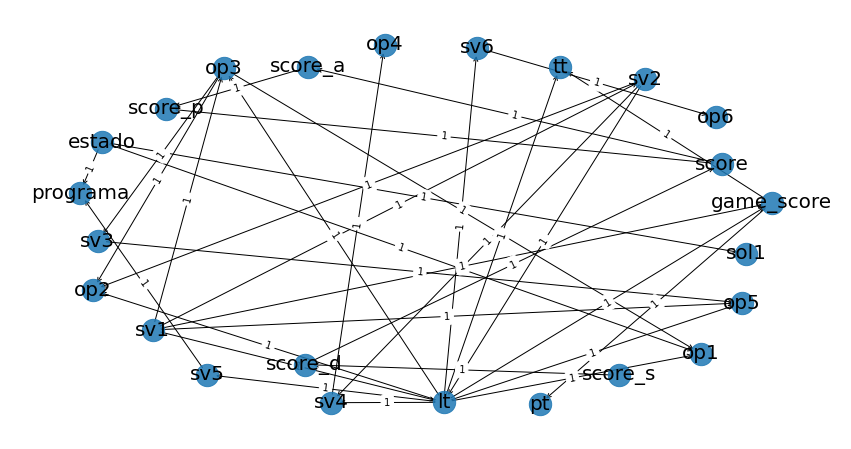

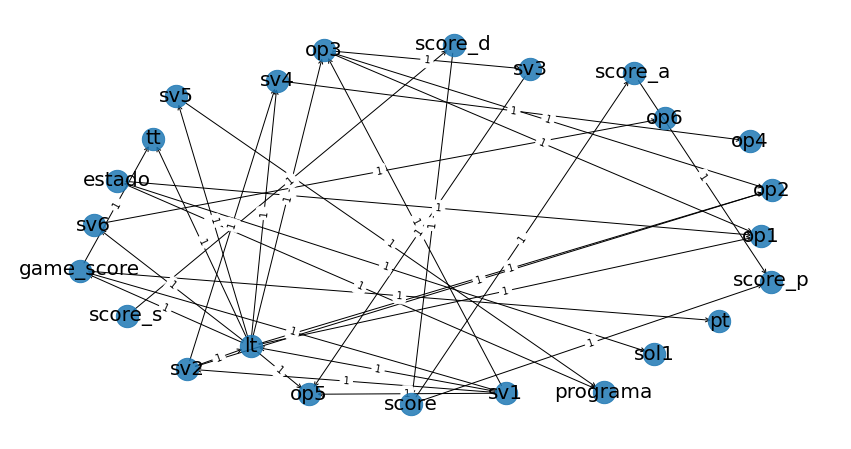

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



FILA N°: 2 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6641 |
+-----------+---------------+
| estado(1) |        0.3359 |
+-----------+---------------+
FILA N°: 3 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":2, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3213 |
+-----------+---------------+
| estado(1) |        0

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5740 |
+-----------+---------------+
| estado(1) |        0.4260 |
+-----------+---------------+
FILA N°: 5 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5408 |
+-----------+---------------+
| estado(1) |        0.4592 |
+-----------+---------------+
FILA N°: 6 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4981 |
+-----------+---------------+
| estado(1) |        0.5019 |
+-----------+---------------+
FILA N°: 7 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4178 |
+-----------+---------------+
| estado(1) |        0.5822 |
+-----------+---------------+
FILA N°: 9 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5775 |
+-----------+---------------+
| estado(1) |        0.4225 |
+-----------+---------------+
FILA N°: 10 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":2, "sol1":6

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5089 |
+-----------+---------------+
| estado(1) |        0.4911 |
+-----------+---------------+
FILA N°: 11 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3616 |
+-----------+---------------+
| estado(1) |        0.6384 |
+-----------+---------------+
FILA N°: 12 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5991 |
+-----------+---------------+
| estado(1) |        0.4009 |
+-----------+---------------+
FILA N°: 14 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3994 |
+-----------+---------------+
| estado(1) |        0.6006 |
+-----------+---------------+
FILA N°: 15 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4153 |
+-----------+---------------+
| estado(1) |        0.5847 |
+-----------+---------------+
FILA N°: 16 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5265 |
+-----------+---------------+
| estado(1) |        0.4735 |
+-----------+---------------+
FILA N°: 17 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":0, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4555 |
+-----------+---------------+
| estado(1) |        0.5445 |
+-----------+---------------+
FILA N°: 20 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5374 |
+-----------+---------------+
| estado(1) |        0.4626 |
+-----------+---------------+
FILA N°: 21 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5514 |
+-----------+---------------+
| estado(1) |        0.4486 |
+-----------+---------------+
FILA N°: 22 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1":2.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5007 |
+-----------+---------------+
| estado(1) |        0.4993 |
+-----------+---------------+
FILA N°: 23 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":3, "score_d":0, "score_s":1, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4561 |
+-----------+---------------+
| estado(1) |        0.5439 |
+-----------+---------------+
FILA N°: 26 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5274 |
+-----------+---------------+
| estado(1) |        0.4726 |
+-----------+---------------+
FILA N°: 27 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6103 |
+-----------+---------------+
| estado(1) |        0.3897 |
+-----------+---------------+
FILA N°: 28 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 29 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4600 |
+-----------+---------------+
| estado(1) |        0.5400 |
+-----------+---------------+
FILA N°: 31 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6133 |
+-----------+---------------+
| estado(1) |        0.3867 |
+-----------+---------------+
FILA N°: 32 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6897 |
+-----------+---------------+
| estado(1) |        0.3103 |
+-----------+---------------+
FILA N°: 33 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7230 |
+-----------+---------------+
| estado(1) |        0.2770 |
+-----------+---------------+
FILA N°: 36 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6995 |
+-----------+---------------+
| estado(1) |        0.3005 |
+-----------+---------------+
FILA N°: 37 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1"

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6207 |
+-----------+---------------+
| estado(1) |        0.3793 |
+-----------+---------------+
FILA N°: 38 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4858 |
+-----------+---------------+
| estado(1) |        0.5142 |
+-----------+---------------+
FILA N°: 39 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 41 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5449 |
+-----------+---------------+
| estado(1) |        0.4551 |
+-----------+---------------+
FILA N°: 42 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1"





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4811 |
+-----------+---------------+
| estado(1) |        0.5189 |
+-----------+---------------+
FILA N°: 43 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6495 |
+-----------+---------------+
| estado(1) |        0.3505 |
+-----------+---------------+
FILA N°: 44 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":2, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6985 |
+-----------+---------------+
| estado(1) |        0.3015 |
+-----------+---------------+
FILA N°: 45 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4811 |
+-----------+---------------+
| estado(1) |        0.5189 |
+-----------+---------------+
FILA N°: 46 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8455 |
+-----------+---------------+
| estado(1) |        0.1545 |
+-----------+---------------+
FILA N°: 47 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":3, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4544 |
+-----------+---------------+
| estado(1) |        0.5456 |
+-----------+---------------+
FILA N°: 48 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":






0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6679 |
+-----------+---------------+
| estado(1) |        0.3321 |
+-----------+---------------+
FILA N°: 49 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5522 |
+-----------+---------------+
| estado(1) |        0.4478 |
+-----------+---------------+
FILA N°: 50 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5517 |
+-----------+---------------+
| estado(1) |        0.4483 |
+-----------+---------------+
FILA N°: 52 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":3, "programa":5, "sol1":3.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5981 |
+-----------+---------------+
| estado(1) |        0.4019 |
+-----------+---------------+
FILA N°: 54 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7914 |
+-----------+---------------+
| estado(1) |        0.2086 |
+-----------+---------------+
FILA N°: 56 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5014 |
+-----------+---------------+
| estado(1) |        0.4986 |
+-----------+---------------+
FILA N°: 59 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":4, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5967 |
+-----------+---------------+
| estado(1) |        0.4033 |
+-----------+---------------+
FILA N°: 60 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":








Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6460 |
+-----------+---------------+
| estado(1) |        0.3540 |
+-----------+---------------+
FILA N°: 61 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":4, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8455 |
+-----------+---------------+
| estado(1) |        0.1545 |
+-----------+---------------+
FILA N°: 62 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5522 |
+-----------+---------------+
| estado(1) |        0.4478 |
+-----------+---------------+
FILA N°: 63 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5894 |
+-----------+---------------+
| estado(1) |        0.4106 |
+-----------+---------------+
FILA N°: 64 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7111 |
+-----------+---------------+
| estado(1) |        0.2889 |
+-----------+---------------+
FILA N°: 65 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7369 |
+-----------+---------------+
| estado(1) |        0.2631 |
+-----------+---------------+
FILA N°: 66 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 67 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7652 |
+-----------+---------------+
| estado(1) |        0.2348 |
+-----------+---------------+
FILA N°: 68 -> P("estado" | [{"lt":6.0, "tt":5.0, "pt":6.0, "game_score":5.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..









0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6378 |
+-----------+---------------+
| estado(1) |        0.3622 |
+-----------+---------------+
FILA N°: 69 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7369 |
+-----------+---------------+
| estado(1) |        0.2631 |
+-----------+---------------+
FILA N°: 70 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1"








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6132 |
+-----------+---------------+
| estado(1) |        0.3868 |
+-----------+---------------+
FILA N°: 72 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8130 |
+-----------+---------------+
| estado(1) |        0.1870 |
+-----------+---------------+
FILA N°: 73 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":2, "programa":5, "sol1":










Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8260 |
+-----------+---------------+
| estado(1) |        0.1740 |
+-----------+---------------+
FILA N°: 74 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7023 |
+-----------+---------------+
| estado(1) |        0.2977 |
+-----------+---------------+
FILA N°: 75 -> P("estado" | [{"lt":5.0, "tt":0.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1":








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5623 |
+-----------+---------------+
| estado(1) |        0.4377 |
+-----------+---------------+
FILA N°: 77 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5694 |
+-----------+---------------+
| estado(1) |        0.4306 |
+-----------+---------------+
FILA N°: 78 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":









0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5517 |
+-----------+---------------+
| estado(1) |        0.4483 |
+-----------+---------------+
FILA N°: 79 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6780 |
+-----------+---------------+
| estado(1) |        0.3220 |
+-----------+---------------+
FILA N°: 80 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [11:25, ?it/s]
Finding Elimination Order: : : 0it [10:35, ?it/s]
Finding Elimination Order: : : 0it [07:33, ?it/s]
Finding Elimination Order: : : 0it [06:33, ?it/s]
0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [05:32, ?it/s]
Finding Elimination Order: : : 0it [04:32, ?it/s]
Finding Elimination Order: : : 0it [03:41, ?it/s]
Finding Elimination Order: : : 0it [03:51, ?it/s]

Finding Elimination Order: : : 0it [04:00, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [01:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6743 |
+-----------+---------------+
| estado(1) |        0.3257 |
+-----------+---------------+
FILA N°: 81 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6747 |
+-----------+---------------+
| estado(1) |        0.3253 |
+-----------+---------------+
FILA N°: 82 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7240 |
+-----------+---------------+
| estado(1) |        0.2760 |
+-----------+---------------+
FILA N°: 87 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6439 |
+-----------+---------------+
| estado(1) |        0.3561 |
+-----------+---------------+
FILA N°: 88 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7535 |
+-----------+---------------+
| estado(1) |        0.2465 |
+-----------+---------------+
FILA N°: 90 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4722 |
+-----------+---------------+
| estado(1) |        0.5278 |
+-----------+---------------+
FILA N°: 91 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":0, "score_d":1, "score_s":1, "programa":5, "sol1":


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7168 |
+-----------+---------------+
| estado(1) |        0.2832 |
+-----------+---------------+
FILA N°: 92 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6747 |
+-----------+---------------+
| estado(1) |        0.3253 |
+-----------+---------------+
FILA N°: 93 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8395 |
+-----------+---------------+
| estado(1) |        0.1605 |
+-----------+---------------+
FILA N°: 98 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7269 |
+-----------+---------------+
| estado(1) |        0.2731 |
+-----------+---------------+
FILA N°: 99 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 102 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 103 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 104 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7482 |
+-----------+---------------+
| estado(1) |        0.2518 |
+-----------+---------------+
FILA N°: 105 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6747 |
+-----------+---------------+
| estado(1) |        0.3253 |
+-----------+---------------+
FILA N°: 106 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7802 |
+-----------+---------------+
| estado(1) |        0.2198 |
+-----------+---------------+
FILA N°: 107 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7331 |
+-----------+---------------+
| estado(1) |        0.2669 |
+-----------+---------------+
FILA N°: 108 -> P("estado" | [{"lt":4.0, "tt":3.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8116 |
+-----------+---------------+
| estado(1) |        0.1884 |
+-----------+---------------+
FILA N°: 109 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7132 |
+-----------+---------------+
| estado(1) |        0.2868 |
+-----------+---------------+
FILA N°: 112 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 113 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6591 |
+-----------+---------------+
| estado(1) |        0.3409 |
+-----------+---------------+
FILA N°: 114 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 115 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6601 |
+-----------+---------------+
| estado(1) |        0.3399 |
+-----------+---------------+
FILA N°: 117 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8218 |
+-----------+---------------+
| estado(1) |        0.1782 |
+-----------+---------------+
FILA N°: 118 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5694 |
+-----------+---------------+
| estado(1) |        0.4306 |
+-----------+---------------+
FILA N°: 120 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6133 |
+-----------+---------------+
| estado(1) |        0.3867 |
+-----------+---------------+
FILA N°: 121 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8246 |
+-----------+---------------+
| estado(1) |        0.1754 |
+-----------+---------------+
FILA N°: 122 -> P("estado" | [{"lt":4.0, "tt":4.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7196 |
+-----------+---------------+
| estado(1) |        0.2804 |
+-----------+---------------+
FILA N°: 123 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6133 |
+-----------+---------------+
| estado(1) |        0.3867 |
+-----------+---------------+
FILA N°: 126 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":4, "score_d":1, "score_s":0, "programa":1, "sol1




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7502 |
+-----------+---------------+
| estado(1) |        0.2498 |
+-----------+---------------+
FILA N°: 127 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4558 |
+-----------+---------------+
| estado(1) |        0.5442 |
+-----------+---------------+
FILA N°: 129 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 130 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 131 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7809 |
+-----------+---------------+
| estado(1) |        0.2191 |
+-----------+---------------+
FILA N°: 133 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7269 |
+-----------+---------------+
| estado(1) |        0.2731 |
+-----------+---------------+
FILA N°: 134 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7111 |
+-----------+---------------+
| estado(1) |        0.2889 |
+-----------+---------------+
FILA N°: 136 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6439 |
+-----------+---------------+
| estado(1) |        0.3561 |
+-----------+---------------+
FILA N°: 137 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":7, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6375 |
+-----------+---------------+
| estado(1) |        0.3625 |
+-----------+---------------+
FILA N°: 138 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8443 |
+-----------+---------------+
| estado(1) |        0.1557 |
+-----------+---------------+
FILA N°: 139 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 140 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7331 |
+-----------+---------------+
| estado(1) |        0.2669 |
+-----------+---------------+
FILA N°: 141 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..






0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8246 |
+-----------+---------------+
| estado(1) |        0.1754 |
+-----------+---------------+
FILA N°: 142 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 145 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7886 |
+-----------+---------------+
| estado(1) |        0.2114 |
+-----------+---------------+
FILA N°: 146 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7671 |
+-----------+---------------+
| estado(1) |        0.2329 |
+-----------+---------------+
FILA N°: 147 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [01:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7652 |
+-----------+---------------+
| estado(1) |        0.2348 |
+-----------+---------------+
FILA N°: 148 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":7, "score_p":1, "score_d":4, "score_s":3, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5941 |
+-----------+---------------+
| estado(1) |        0.4059 |
+-----------+---------------+
FILA N°: 149 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6716 |
+-----------+---------------+
| estado(1) |        0.3284 |
+-----------+---------------+
FILA N°: 151 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
FILA N°: 152 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol









0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [01:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8218 |
+-----------+---------------+
| estado(1) |        0.1782 |
+-----------+---------------+
FILA N°: 153 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 154 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 155 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8395 |
+-----------+---------------+
| estado(1) |        0.1605 |
+-----------+---------------+
FILA N°: 156 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8716 |
+-----------+---------------+
| estado(1) |        0.1284 |
+-----------+---------------+
FILA N°: 157 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4709 |
+-----------+---------------+
| estado(1) |        0.5291 |
+-----------+---------------+
FILA N°: 158 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7240 |
+-----------+---------------+
| estado(1) |        0.2760 |
+-----------+---------------+
FILA N°: 159 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7652 |
+-----------+---------------+
| estado(1) |        0.2348 |
+-----------+---------------+
FILA N°: 160 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 161 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7102 |
+-----------+---------------+
| estado(1) |        0.2898 |
+-----------+---------------+
FILA N°: 162 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6390 |
+-----------+---------------+
| estado(1) |        0.3610 |
+-----------+---------------+
FILA N°: 163 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8137 |
+-----------+---------------+
| estado(1) |        0.1863 |
+-----------+---------------+
FILA N°: 164 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6601 |
+-----------+---------------+
| estado(1) |        0.3399 |
+-----------+---------------+
FILA N°: 165 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7667 |
+-----------+---------------+
| estado(1) |        0.2333 |
+-----------+---------------+
FILA N°: 166 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7705 |
+-----------+---------------+
| estado(1) |        0.2295 |
+-----------+---------------+
FILA N°: 167 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6350 |
+-----------+---------------+
| estado(1) |        0.3650 |
+-----------+---------------+
FILA N°: 168 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":2, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6394 |
+-----------+---------------+
| estado(1) |        0.3606 |
+-----------+---------------+
FILA N°: 170 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7566 |
+-----------+---------------+
| estado(1) |        0.2434 |
+-----------+---------------+
FILA N°: 171 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7665 |
+-----------+---------------+
| estado(1) |        0.2335 |
+-----------+---------------+
FILA N°: 172 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7766 |
+-----------+---------------+
| estado(1) |        0.2234 |
+-----------+---------------+
FILA N°: 174 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6747 |
+-----------+---------------+
| estado(1) |        0.3253 |
+-----------+---------------+
FILA N°: 175 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":4, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 177 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7652 |
+-----------+---------------+
| estado(1) |        0.2348 |
+-----------+---------------+
FILA N°: 178 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":4, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6637 |
+-----------+---------------+
| estado(1) |        0.3363 |
+-----------+---------------+
FILA N°: 179 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6013 |
+-----------+---------------+
| estado(1) |        0.3987 |
+-----------+---------------+
FILA N°: 180 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8330 |
+-----------+---------------+
| estado(1) |        0.1670 |
+-----------+---------------+
FILA N°: 181 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8246 |
+-----------+---------------+
| estado(1) |        0.1754 |
+-----------+---------------+
FILA N°: 182 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 183 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 184 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6778 |
+-----------+---------------+
| estado(1) |        0.3222 |
+-----------+---------------+
FILA N°: 185 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7527 |
+-----------+---------------+
| estado(1) |        0.2473 |
+-----------+---------------+
FILA N°: 186 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5449 |
+-----------+---------------+
| estado(1) |        0.4551 |
+-----------+---------------+
FILA N°: 187 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7122 |
+-----------+---------------+
| estado(1) |        0.2878 |
+-----------+---------------+
FILA N°: 188 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":4, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 189 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 191 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":6, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7483 |
+-----------+---------------+
| estado(1) |        0.2517 |
+-----------+---------------+
FILA N°: 192 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5894 |
+-----------+---------------+
| estado(1) |        0.4106 |
+-----------+---------------+
FILA N°: 193 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6132 |
+-----------+---------------+
| estado(1) |        0.3868 |
+-----------+---------------+
FILA N°: 194 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":2, "programa":2, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5089 |
+-----------+---------------+
| estado(1) |        0.4911 |
+-----------+---------------+
FILA N°: 195 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8397 |
+-----------+---------------+
| estado(1) |        0.1603 |
+-----------+---------------+
FILA N°: 196 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8716 |
+-----------+---------------+
| estado(1) |        0.1284 |
+-----------+---------------+
FILA N°: 197 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":1, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 199 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8715 |
+-----------+---------------+
| estado(1) |        0.1285 |
+-----------+---------------+
FILA N°: 200 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8137 |
+-----------+---------------+
| estado(1) |        0.1863 |
+-----------+---------------+
FILA N°: 201 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":0, "score_d":1, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7369 |
+-----------+---------------+
| estado(1) |        0.2631 |
+-----------+---------------+
FILA N°: 203 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5696 |
+-----------+---------------+
| estado(1) |        0.4304 |
+-----------+---------------+
FILA N°: 204 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5449 |
+-----------+---------------+
| estado(1) |        0.4551 |
+-----------+---------------+
FILA N°: 205 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":5.0, "game_score":4.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5153 |
+-----------+---------------+
| estado(1) |        0.4847 |
+-----------+---------------+
FILA N°: 206 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 207 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6369 |
+-----------+---------------+
| estado(1) |        0.3631 |
+-----------+---------------+
FILA N°: 208 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":5, "sol1

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7168 |
+-----------+---------------+
| estado(1) |        0.2832 |
+-----------+---------------+
FILA N°: 210 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":4, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7479 |
+-----------+---------------+
| estado(1) |        0.2521 |
+-----------+---------------+
FILA N°: 211 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 212 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 213 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8533 |
+-----------+---------------+
| estado(1) |        0.1467 |
+-----------+---------------+
FILA N°: 214 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 215 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7766 |
+-----------+---------------+
| estado(1) |        0.2234 |
+-----------+---------------+
FILA N°: 216 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":3, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6098 |
+-----------+---------------+
| estado(1) |        0.3902 |
+-----------+---------------+
FILA N°: 217 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":2, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6530 |
+-----------+---------------+
| estado(1) |        0.3470 |
+-----------+---------------+
FILA N°: 218 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7369 |
+-----------+---------------+
| estado(1) |        0.2631 |
+-----------+---------------+
FILA N°: 219 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":1, "score_p":3, "score_d":1, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8041 |
+-----------+---------------+
| estado(1) |        0.1959 |
+-----------+---------------+
FILA N°: 220 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5136 |
+-----------+---------------+
| estado(1) |        0.4864 |
+-----------+---------------+
FILA N°: 221 -> P("estado" | [{"lt":4.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7509 |
+-----------+---------------+
| estado(1) |        0.2491 |
+-----------+---------------+
FILA N°: 223 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 224 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 225 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":1, "score_a":1, "score_p":1, "score_d":0, "score_s":0, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7122 |
+-----------+---------------+
| estado(1) |        0.2878 |
+-----------+---------------+
FILA N°: 227 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 229 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 230 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7369 |
+-----------+---------------+
| estado(1) |        0.2631 |
+-----------+---------------+
FILA N°: 232 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7636 |
+-----------+---------------+
| estado(1) |        0.2364 |
+-----------+---------------+
FILA N°: 233 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 234 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7369 |
+-----------+---------------+
| estado(1) |        0.2631 |
+-----------+---------------+
FILA N°: 236 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 237 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6679 |
+-----------+---------------+
| estado(1) |        0.3321 |
+-----------+---------------+
FILA N°: 238 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7766 |
+-----------+---------------+
| estado(1) |        0.2234 |
+-----------+---------------+
FILA N°: 240 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":0, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5775 |
+-----------+---------------+
| estado(1) |        0.4225 |
+-----------+---------------+
FILA N°: 241 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8041 |
+-----------+---------------+
| estado(1) |        0.1959 |
+-----------+---------------+
FILA N°: 242 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6394 |
+-----------+---------------+
| estado(1) |        0.3606 |
+-----------+---------------+
FILA N°: 243 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6207 |
+-----------+---------------+
| estado(1) |        0.3793 |
+-----------+---------------+
FILA N°: 244 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6521 |
+-----------+---------------+
| estado(1) |        0.3479 |
+-----------+---------------+
FILA N°: 245 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6003 |
+-----------+---------------+
| estado(1) |        0.3997 |
+-----------+---------------+
FILA N°: 246 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8330 |
+-----------+---------------+
| estado(1) |        0.1670 |
+-----------+---------------+
FILA N°: 247 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6103 |
+-----------+---------------+
| estado(1) |        0.3897 |
+-----------+---------------+
FILA N°: 248 -> P("estado" | [{"lt":4.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":3, "score_d":3, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7452 |
+-----------+---------------+
| estado(1) |        0.2548 |
+-----------+---------------+
FILA N°: 249 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 250 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 251 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7379 |
+-----------+---------------+
| estado(1) |        0.2621 |
+-----------+---------------+
FILA N°: 252 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8509 |
+-----------+---------------+
| estado(1) |        0.1491 |
+-----------+---------------+
FILA N°: 253 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 255 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5274 |
+-----------+---------------+
| estado(1) |        0.4726 |
+-----------+---------------+
FILA N°: 256 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7240 |
+-----------+---------------+
| estado(1) |        0.2760 |
+-----------+---------------+
FILA N°: 257 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5449 |
+-----------+---------------+
| estado(1) |        0.4551 |
+-----------+---------------+
FILA N°: 258 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7705 |
+-----------+---------------+
| estado(1) |        0.2295 |
+-----------+---------------+
FILA N°: 259 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":2, "sol1":3.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3250 |
+-----------+---------------+
| estado(1) |        0.6750 |
+-----------+---------------+
FILA N°: 260 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7122 |
+-----------+---------------+
| estado(1) |        0.2878 |
+-----------+---------------+
FILA N°: 261 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5138 |
+-----------+---------------+
| estado(1) |        0.4862 |
+-----------+---------------+
FILA N°: 262 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":3, "programa":2, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6778 |
+-----------+---------------+
| estado(1) |        0.3222 |
+-----------+---------------+
FILA N°: 263 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7482 |
+-----------+---------------+
| estado(1) |        0.2518 |
+-----------+---------------+
FILA N°: 265 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7769 |
+-----------+---------------+
| estado(1) |        0.2231 |
+-----------+---------------+
FILA N°: 266 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7948 |
+-----------+---------------+
| estado(1) |        0.2052 |
+-----------+---------------+
FILA N°: 267 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7571 |
+-----------+---------------+
| estado(1) |        0.2429 |
+-----------+---------------+
FILA N°: 269 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6590 |
+-----------+---------------+
| estado(1) |        0.3410 |
+-----------+---------------+
FILA N°: 270 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6132 |
+-----------+---------------+
| estado(1) |        0.3868 |
+-----------+---------------+
FILA N°: 271 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 272 -> P("estado" | [{"lt":6.0, "tt":0.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6906 |
+-----------+---------------+
| estado(1) |        0.3094 |
+-----------+---------------+
FILA N°: 273 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 274 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8137 |
+-----------+---------------+
| estado(1) |        0.1863 |
+-----------+---------------+
FILA N°: 275 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7368 |
+-----------+---------------+
| estado(1) |        0.2632 |
+-----------+---------------+
FILA N°: 276 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6608 |
+-----------+---------------+
| estado(1) |        0.3392 |
+-----------+---------------+
FILA N°: 277 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7055 |
+-----------+---------------+
| estado(1) |        0.2945 |
+-----------+---------------+
FILA N°: 278 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7705 |
+-----------+---------------+
| estado(1) |        0.2295 |
+-----------+---------------+
FILA N°: 279 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7469 |
+-----------+---------------+
| estado(1) |        0.2531 |
+-----------+---------------+
FILA N°: 280 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7483 |
+-----------+---------------+
| estado(1) |        0.2517 |
+-----------+---------------+
FILA N°: 281 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 282 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6493 |
+-----------+---------------+
| estado(1) |        0.3507 |
+-----------+---------------+
FILA N°: 283 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7809 |
+-----------+---------------+
| estado(1) |        0.2191 |
+-----------+---------------+
FILA N°: 284 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5672 |
+-----------+---------------+
| estado(1) |        0.4328 |
+-----------+---------------+
FILA N°: 286 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6133 |
+-----------+---------------+
| estado(1) |        0.3867 |
+-----------+---------------+
FILA N°: 287 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7636 |
+-----------+---------------+
| estado(1) |        0.2364 |
+-----------+---------------+
FILA N°: 289 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7269 |
+-----------+---------------+
| estado(1) |        0.2731 |
+-----------+---------------+
FILA N°: 290 -> P("estado" | [{"lt":2.0, "tt":5.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8716 |
+-----------+---------------+
| estado(1) |        0.1284 |
+-----------+---------------+
FILA N°: 291 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 292 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8261 |
+-----------+---------------+
| estado(1) |        0.1739 |
+-----------+---------------+
FILA N°: 293 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8395 |
+-----------+---------------+
| estado(1) |        0.1605 |
+-----------+---------------+
FILA N°: 295 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7129 |
+-----------+---------------+
| estado(1) |        0.2871 |
+-----------+---------------+
FILA N°: 296 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7055 |
+-----------+---------------+
| estado(1) |        0.2945 |
+-----------+---------------+
FILA N°: 297 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8476 |
+-----------+---------------+
| estado(1) |        0.1524 |
+-----------+---------------+
FILA N°: 299 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8455 |
+-----------+---------------+
| estado(1) |        0.1545 |
+-----------+---------------+
FILA N°: 301 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8443 |
+-----------+---------------+
| estado(1) |        0.1557 |
+-----------+---------------+
FILA N°: 303 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8716 |
+-----------+---------------+
| estado(1) |        0.1284 |
+-----------+---------------+
FILA N°: 304 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 306 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 307 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8862 |
+-----------+---------------+
| estado(1) |        0.1138 |
+-----------+---------------+
FILA N°: 308 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 309 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7671 |
+-----------+---------------+
| estado(1) |        0.2329 |
+-----------+---------------+
FILA N°: 310 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6743 |
+-----------+---------------+
| estado(1) |        0.3257 |
+-----------+---------------+
FILA N°: 311 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8533 |
+-----------+---------------+
| estado(1) |        0.1467 |
+-----------+---------------+
FILA N°: 313 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7469 |
+-----------+---------------+
| estado(1) |        0.2531 |
+-----------+---------------+
FILA N°: 315 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7055 |
+-----------+---------------+
| estado(1) |        0.2945 |
+-----------+---------------+
FILA N°: 316 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6936 |
+-----------+---------------+
| estado(1) |        0.3064 |
+-----------+---------------+
FILA N°: 317 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8261 |
+-----------+---------------+
| estado(1) |        0.1739 |
+-----------+---------------+
FILA N°: 318 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7889 |
+-----------+---------------+
| estado(1) |        0.2111 |
+-----------+---------------+
FILA N°: 319 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":2, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6736 |
+-----------+---------------+
| estado(1) |        0.3264 |
+-----------+---------------+
FILA N°: 320 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 321 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6398 |
+-----------+---------------+
| estado(1) |        0.3602 |
+-----------+---------------+
FILA N°: 322 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 324 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7527 |
+-----------+---------------+
| estado(1) |        0.2473 |
+-----------+---------------+
FILA N°: 325 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":1, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8216 |
+-----------+---------------+
| estado(1) |        0.1784 |
+-----------+---------------+
FILA N°: 326 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":2, "score_d":1, "score_s":1, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 327 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 328 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 329 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7129 |
+-----------+---------------+
| estado(1) |        0.2871 |
+-----------+---------------+
FILA N°: 330 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 331 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8018 |
+-----------+---------------+
| estado(1) |        0.1982 |
+-----------+---------------+
FILA N°: 332 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6897 |
+-----------+---------------+
| estado(1) |        0.3103 |
+-----------+---------------+
FILA N°: 333 -> P("estado" | [{"lt":5.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6841 |
+-----------+---------------+
| estado(1) |        0.3159 |
+-----------+---------------+
FILA N°: 334 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 335 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 337 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 338 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6798 |
+-----------+---------------+
| estado(1) |        0.3202 |
+-----------+---------------+
FILA N°: 341 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 342 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 345 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7802 |
+-----------+---------------+
| estado(1) |        0.2198 |
+-----------+---------------+
FILA N°: 346 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8449 |
+-----------+---------------+
| estado(1) |        0.1551 |
+-----------+---------------+
FILA N°: 349 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 350 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7332 |
+-----------+---------------+
| estado(1) |        0.2668 |
+-----------+---------------+
FILA N°: 351 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 353 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":4, "score_s":4, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 354 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8455 |
+-----------+---------------+
| estado(1) |        0.1545 |
+-----------+---------------+
FILA N°: 355 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7636 |
+-----------+---------------+
| estado(1) |        0.2364 |
+-----------+---------------+
FILA N°: 358 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 359 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6215 |
+-----------+---------------+
| estado(1) |        0.3785 |
+-----------+---------------+
FILA N°: 360 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "so





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7630 |
+-----------+---------------+
| estado(1) |        0.2370 |
+-----------+---------------+
FILA N°: 361 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7122 |
+-----------+---------------+
| estado(1) |        0.2878 |
+-----------+---------------+
FILA N°: 363 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7067 |
+-----------+---------------+
| estado(1) |        0.2933 |
+-----------+---------------+
FILA N°: 364 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 365 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 366 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8533 |
+-----------+---------------+
| estado(1) |        0.1467 |
+-----------+---------------+
FILA N°: 367 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":0, "score_s":1, "programa":3, "sol1

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8397 |
+-----------+---------------+
| estado(1) |        0.1603 |
+-----------+---------------+
FILA N°: 369 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7703 |
+-----------+---------------+
| estado(1) |        0.2297 |
+-----------+---------------+
FILA N°: 370 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6624 |
+-----------+---------------+
| estado(1) |        0.3376 |
+-----------+---------------+
FILA N°: 375 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6903 |
+-----------+---------------+
| estado(1) |        0.3097 |
+-----------+---------------+
FILA N°: 376 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8533 |
+-----------+---------------+
| estado(1) |        0.1467 |
+-----------+---------------+
FILA N°: 378 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 379 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5522 |
+-----------+---------------+
| estado(1) |        0.4478 |
+-----------+---------------+
FILA N°: 380 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 381 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 383 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7902 |
+-----------+---------------+
| estado(1) |        0.2098 |
+-----------+---------------+
FILA N°: 384 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":1, "programa":3, "sol1





0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 386 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7191 |
+-----------+---------------+
| estado(1) |        0.2809 |
+-----------+---------------+
FILA N°: 387 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [59:10, ?it/s]
Finding Elimination Order: : : 0it [54:38, ?it/s]
Finding Elimination Order: : : 0it [54:18, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [52:57, ?it/s]
Finding Elimination Order: : : 0it [51:56, ?it/s]
Finding Elimination Order: : : 0it [52:05, ?it/s]
Finding Elimination Order: : : 0it [51:05, ?it/s]

Finding Elimination Order: : : 0it [50:34, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [01:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7671 |
+-----------+---------------+
| estado(1) |        0.2329 |
+-----------+---------------+
FILA N°: 388 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7479 |
+-----------+---------------+
| estado(1) |        0.2521 |
+-----------+---------------+
FILA N°: 389 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7948 |
+-----------+---------------+
| estado(1) |        0.2052 |
+-----------+---------------+
FILA N°: 394 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8369 |
+-----------+---------------+
| estado(1) |        0.1631 |
+-----------+---------------+
FILA N°: 395 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
FILA N°: 396 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7854 |
+-----------+---------------+
| estado(1) |        0.2146 |
+-----------+---------------+
FILA N°: 397 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6743 |
+-----------+---------------+
| estado(1) |        0.3257 |
+-----------+---------------+
FILA N°: 398 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 399 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7769 |
+-----------+---------------+
| estado(1) |        0.2231 |
+-----------+---------------+
FILA N°: 401 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 402 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 404 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7929 |
+-----------+---------------+
| estado(1) |        0.2071 |
+-----------+---------------+
FILA N°: 405 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 407 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7636 |
+-----------+---------------+
| estado(1) |        0.2364 |
+-----------+---------------+
FILA N°: 408 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8061 |
+-----------+---------------+
| estado(1) |        0.1939 |
+-----------+---------------+
FILA N°: 409 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":4, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7571 |
+-----------+---------------+
| estado(1) |        0.2429 |
+-----------+---------------+
FILA N°: 410 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:10, ?it/s]
0it [00:10, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7479 |
+-----------+---------------+
| estado(1) |        0.2521 |
+-----------+---------------+
FILA N°: 412 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..



Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7669 |
+-----------+---------------+
| estado(1) |        0.2331 |
+-----------+---------------+
FILA N°: 413 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
FILA N°: 414 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7703 |
+-----------+---------------+
| estado(1) |        0.2297 |
+-----------+---------------+
FILA N°: 415 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6091 |
+-----------+---------------+
| estado(1) |        0.3909 |
+-----------+---------------+
FILA N°: 417 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8455 |
+-----------+---------------+
| estado(1) |        0.1545 |
+-----------+---------------+
FILA N°: 419 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7479 |
+-----------+---------------+
| estado(1) |        0.2521 |
+-----------+---------------+
FILA N°: 421 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8397 |
+-----------+---------------+
| estado(1) |        0.1603 |
+-----------+---------------+
FILA N°: 422 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":4, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7863 |
+-----------+---------------+
| estado(1) |        0.2137 |
+-----------+---------------+
FILA N°: 424 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8716 |
+-----------+---------------+
| estado(1) |        0.1284 |
+-----------+---------------+
FILA N°: 425 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 427 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 428 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7626 |
+-----------+---------------+
| estado(1) |        0.2374 |
+-----------+---------------+
FILA N°: 430 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8226 |
+-----------+---------------+
| estado(1) |        0.1774 |
+-----------+---------------+
FILA N°: 431 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7107 |
+-----------+---------------+
| estado(1) |        0.2893 |
+-----------+---------------+
FILA N°: 432 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
FILA N°: 433 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7332 |
+-----------+---------------+
| estado(1) |        0.2668 |
+-----------+---------------+
FILA N°: 434 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8862 |
+-----------+---------------+
| estado(1) |        0.1138 |
+-----------+---------------+
FILA N°: 435 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7479 |
+-----------+---------------+
| estado(1) |        0.2521 |
+-----------+---------------+
FILA N°: 436 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8455 |
+-----------+---------------+
| estado(1) |        0.1545 |
+-----------+---------------+
FILA N°: 437 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7889 |
+-----------+---------------+
| estado(1) |        0.2111 |
+-----------+---------------+
FILA N°: 438 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 439 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8028 |
+-----------+---------------+
| estado(1) |        0.1972 |
+-----------+---------------+
FILA N°: 441 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7889 |
+-----------+---------------+
| estado(1) |        0.2111 |
+-----------+---------------+
FILA N°: 442 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
FILA N°: 443 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 444 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 445 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]









+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8443 |
+-----------+---------------+
| estado(1) |        0.1557 |
+-----------+---------------+
FILA N°: 448 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7889 |
+-----------+---------------+
| estado(1) |        0.2111 |
+-----------+---------------+
FILA N°: 449 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 451 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 452 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8533 |
+-----------+---------------+
| estado(1) |        0.1467 |
+-----------+---------------+
FILA N°: 453 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 454 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1









0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 455 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 456 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 457 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..











Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7630 |
+-----------+---------------+
| estado(1) |        0.2370 |
+-----------+---------------+
FILA N°: 458 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 459 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 460 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 461 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 462 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
FILA N°: 463 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7962 |
+-----------+---------------+
| estado(1) |        0.2038 |
+-----------+---------------+
FILA N°: 464 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7962 |
+-----------+---------------+
| estado(1) |        0.2038 |
+-----------+---------------+
FILA N°: 465 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8311 |
+-----------+---------------+
| estado(1) |        0.1689 |
+-----------+---------------+
FILA N°: 466 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
[[331   4]
 [ 26  13]]
RESULTADOS DEL ENTRENAMIENTO:
(TRAIN) Fold 3 Accuracy          : 0.9197860962566845
(TRAIN) Fold 3 Balanced Accuracy : 0.84593837535014
(TRAIN) Fold 3 Precision Score   : 0.9582994120307554
(TRAIN) Fold 3 Recall Score      : 0.9197860962566845
(TRAIN) Fold 3 ROC AUC           : 0.6606965174129352
(TRAIN) Fold 3 Class Ratio       : 0.10427807486631016
FIN DE SECCION DE ENTRENAMIENTO, FOLD:  3
INICIO DE SECCION DE PRUEBAS, FOLD:  3
FILA N°: 1 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+-----------












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6132 |
+-----------+---------------+
| estado(1) |        0.3868 |
+-----------+---------------+
FILA N°: 13 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5935 |
+-----------+---------------+
| estado(1) |        0.4065 |
+-----------+---------------+
FILA N°: 18 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4153 |
+-----------+---------------+
| estado(1) |        0.5847 |
+-----------+---------------+
FILA N°: 19 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3102 |
+-----------+---------------+
| estado(1) |        0.6898 |
+-----------+---------------+
FILA N°: 24 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":













0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4811 |
+-----------+---------------+
| estado(1) |        0.5189 |
+-----------+---------------+
FILA N°: 25 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5961 |
+-----------+---------------+
| estado(1) |        0.4039 |
+-----------+---------------+
FILA N°: 30 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1"


Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6112 |
+-----------+---------------+
| estado(1) |        0.3888 |
+-----------+---------------+
FILA N°: 34 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5884 |
+-----------+---------------+
| estado(1) |        0.4116 |
+-----------+---------------+
FILA N°: 35 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6780 |
+-----------+---------------+
| estado(1) |        0.3220 |
+-----------+---------------+
FILA N°: 51 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":2, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3710 |
+-----------+---------------+
| estado(1) |        0.6290 |
+-----------+---------------+
FILA N°: 53 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6633 |
+-----------+---------------+
| estado(1) |        0.3367 |
+-----------+---------------+
FILA N°: 55 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5916 |
+-----------+---------------+
| estado(1) |        0.4084 |
+-----------+---------------+
FILA N°: 57 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":













0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s][A

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 58 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5533 |
+-----------+---------------+
| estado(1) |        0.4467 |
+-----------+---------------+
FILA N°: 71 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7802 |
+-----------+---------------+
| estado(1) |        0.2198 |
+-----------+---------------+
FILA N°: 83 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6610 |
+-----------+---------------+
| estado(1) |        0.3390 |
+-----------+---------------+
FILA N°: 85 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7653 |
+-----------+---------------+
| estado(1) |        0.2347 |
+-----------+---------------+
FILA N°: 94 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6601 |
+-----------+---------------+
| estado(1) |        0.3399 |
+-----------+---------------+
FILA N°: 95 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7571 |
+-----------+---------------+
| estado(1) |        0.2429 |
+-----------+---------------+
FILA N°: 96 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":














0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 100 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7769 |
+-----------+---------------+
| estado(1) |        0.2231 |
+-----------+---------------+
FILA N°: 101 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:10, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8443 |
+-----------+---------------+
| estado(1) |        0.1557 |
+-----------+---------------+
FILA N°: 110 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7671 |
+-----------+---------------+
| estado(1) |        0.2329 |
+-----------+---------------+
FILA N°: 111 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7086 |
+-----------+---------------+
| estado(1) |        0.2914 |
+-----------+---------------+
FILA N°: 116 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol















0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7566 |
+-----------+---------------+
| estado(1) |        0.2434 |
+-----------+---------------+
FILA N°: 119 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 124 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 125 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 128 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1
















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7215 |
+-----------+---------------+
| estado(1) |        0.2785 |
+-----------+---------------+
FILA N°: 132 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8132 |
+-----------+---------------+
| estado(1) |        0.1868 |
+-----------+---------------+
FILA N°: 135 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:10, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5775 |
+-----------+---------------+
| estado(1) |        0.4225 |
+-----------+---------------+
FILA N°: 144 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":0, "sv6":1, "score":1, "score_a":1, "score_p":0, "score_d":0, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7249 |
+-----------+---------------+
| estado(1) |        0.2751 |
+-----------+---------------+
FILA N°: 150 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4600 |
+-----------+---------------+
| estado(1) |        0.5400 |
+-----------+---------------+
FILA N°: 169 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1
















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7479 |
+-----------+---------------+
| estado(1) |        0.2521 |
+-----------+---------------+
FILA N°: 173 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 176 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 190 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6493 |
+-----------+---------------+
| estado(1) |        0.3507 |
+-----------+---------------+
FILA N°: 198 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":5, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 202 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:10, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6070 |
+-----------+---------------+
| estado(1) |        0.3930 |
+-----------+---------------+
FILA N°: 209 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8533 |
+-----------+---------------+
| estado(1) |        0.1467 |
+-----------+---------------+
FILA N°: 222 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8132 |
+-----------+---------------+
| estado(1) |        0.1868 |
+-----------+---------------+
FILA N°: 226 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:10, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7766 |
+-----------+---------------+
| estado(1) |        0.2234 |
+-----------+---------------+
FILA N°: 228 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 231 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8246 |
+-----------+---------------+
| estado(1) |        0.1754 |
+-----------+---------------+
FILA N°: 235 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]



















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8051 |
+-----------+---------------+
| estado(1) |        0.1949 |
+-----------+---------------+
FILA N°: 239 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7130 |
+-----------+---------------+
| estado(1) |        0.2870 |
+-----------+---------------+
FILA N°: 254 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 264 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7269 |
+-----------+---------------+
| estado(1) |        0.2731 |
+-----------+---------------+
FILA N°: 268 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5935 |
+-----------+---------------+
| estado(1) |        0.4065 |
+-----------+---------------+
FILA N°: 288 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":4.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":0, "score_p":2, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8218 |
+-----------+---------------+
| estado(1) |        0.1782 |
+-----------+---------------+
FILA N°: 294 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 298 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8108 |
+-----------+---------------+
| estado(1) |        0.1892 |
+-----------+---------------+
FILA N°: 300 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":6, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8800 |
+-----------+---------------+
| estado(1) |        0.1200 |
+-----------+---------------+
FILA N°: 305 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5961 |
+-----------+---------------+
| estado(1) |        0.4039 |
+-----------+---------------+
FILA N°: 312 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":1, "programa":3, "sol


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7705 |
+-----------+---------------+
| estado(1) |        0.2295 |
+-----------+---------------+
FILA N°: 314 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8231 |
+-----------+---------------+
| estado(1) |        0.1769 |
+-----------+---------------+
FILA N°: 323 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6493 |
+-----------+---------------+
| estado(1) |        0.3507 |
+-----------+---------------+
FILA N°: 339 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":3, "score_s":4, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4882 |
+-----------+---------------+
| estado(1) |        0.5118 |
+-----------+---------------+
FILA N°: 340 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:10, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 343 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8030 |
+-----------+---------------+
| estado(1) |        0.1970 |
+-----------+---------------+
FILA N°: 344 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8137 |
+-----------+---------------+
| estado(1) |        0.1863 |
+-----------+---------------+
FILA N°: 347 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 348 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7769 |
+-----------+---------------+
| estado(1) |        0.2231 |
+-----------+---------------+
FILA N°: 352 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8715 |
+-----------+---------------+
| estado(1) |        0.1285 |
+-----------+---------------+
FILA N°: 356 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1



















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [25:34, ?it/s]
Finding Elimination Order: : : 0it [22:14, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 357 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 362 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1


Finding Elimination Order: : : 0it [21:03, ?it/s]
Finding Elimination Order: : : 0it [19:32, ?it/s]
Finding Elimination Order: : : 0it [18:31, ?it/s]
Finding Elimination Order: : : 0it [16:10, ?it/s]
Finding Elimination Order: : : 0it [14:39, ?it/s]
Finding Elimination Order: : : 0it [13:58, ?it/s]
Finding Elimination Order: : : 0it [13:58, ?it/s]
Finding Elimination Order: : : 0it [12:48, ?it/s]
Finding Elimination Order: : : 0it [11:27, ?it/s]
Finding Elimination Order: : : 0it [09:25, ?it/s]
Finding Elimination Order: : : 0it [08:45, ?it/s]
Finding Elimination Order: : : 0it [07:24, ?it/s]
Finding Elimination Order: : : 0it [05:43, ?it/s]
Finding Elimination Order: : : 0it [05:43, ?it/s]
Finding Elimination Order: : : 0it [02:10, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6905 |
+-----------+---------------+
| estado(1) |        0.3095 |
+-----------+---------------+
FILA N°: 368 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7217 |
+-----------+---------------+
| estado(1) |        0.2783 |
+-----------+---------------+
FILA N°: 371 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5845 |
+-----------+---------------+
| estado(1) |        0.4155 |
+-----------+---------------+
FILA N°: 372 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 373 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6743 |
+-----------+---------------+
| estado(1) |        0.3257 |
+-----------+---------------+
FILA N°: 374 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7469 |
+-----------+---------------+
| estado(1) |        0.2531 |
+-----------+---------------+
FILA N°: 377 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4884 |
+-----------+---------------+
| estado(1) |        0.5116 |
+-----------+---------------+
FILA N°: 382 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8395 |
+-----------+---------------+
| estado(1) |        0.1605 |
+-----------+---------------+
FILA N°: 385 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8591 |
+-----------+---------------+
| estado(1) |        0.1409 |
+-----------+---------------+
FILA N°: 392 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5584 |
+-----------+---------------+
| estado(1) |        0.4416 |
+-----------+---------------+
FILA N°: 393 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6098 |
+-----------+---------------+
| estado(1) |        0.3902 |
+-----------+---------------+
FILA N°: 403 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8780 |
+-----------+---------------+
| estado(1) |        0.1220 |
+-----------+---------------+
FILA N°: 406 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":3, "programa":4, "sol1




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8357 |
+-----------+---------------+
| estado(1) |        0.1643 |
+-----------+---------------+
FILA N°: 416 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":4.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8059 |
+-----------+---------------+
| estado(1) |        0.1941 |
+-----------+---------------+
FILA N°: 418 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8715 |
+-----------+---------------+
| estado(1) |        0.1285 |
+-----------+---------------+
FILA N°: 423 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8443 |
+-----------+---------------+
| estado(1) |        0.1557 |
+-----------+---------------+
FILA N°: 426 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7963 |
+-----------+---------------+
| estado(1) |        0.2037 |
+-----------+---------------+
FILA N°: 440 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8397 |
+-----------+---------------+
| estado(1) |        0.1603 |
+-----------+---------------+
FILA N°: 447 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8951 |
+-----------+---------------+
| estado(1) |        0.1049 |
+-----------+---------------+
FILA N°: 450 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8371 |
+-----------+---------------+
| estado(1) |        0.1629 |
+-----------+---------------+
[[79  4]
 [ 6  4]]
RESULTADOS DEL ENTRENAMIENTO:
(TEST) Fold 3 Accuracy          : 0.8924731182795699
(TEST) Fold 3 Balanced Accuracy : 0.7147058823529412
(TEST) Fold 3 Precision Score   : 0.9043399404067884
(TEST) Fold 3 Recall Score      : 0.8924731182795699
(TEST) F

Finding Elimination Order: : : 0it [00:03, ?it/s]


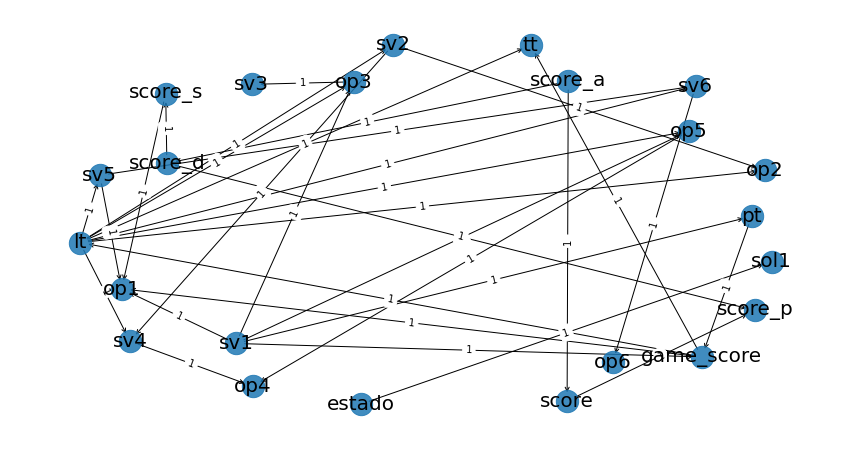

Finding Elimination Order: : : 0it [02:18, ?it/s]
Finding Elimination Order: : : 0it [01:37, ?it/s]
Finding Elimination Order: : : 0it [00:36, ?it/s]


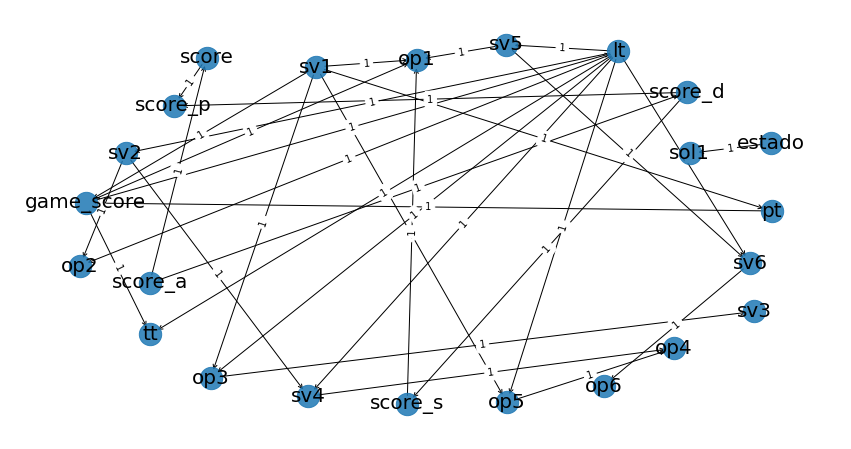

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

COLUMNA ELIMINADA DE LA INFERENCIA:  programa
FILA N°: 1 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 4 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| es


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 6 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 7 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 8 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":1, "sol1":6.0}]
[bnlearn] >Variable Elim


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 9 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 13 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable Eli



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 16 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 18 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 19 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 20 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 21 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 22 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "sol1":2.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4950 |
+-----------+---------------+
| estado(1) |        0.5050 |
+-----------+---------------+
FILA N°: 23 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":3, "score_d":0, "score_s":1, "sol1":1.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5049 |
+-----------+---------------+
| estado(1) |        0.4951 |
+-----------+---------------+
FILA N°: 24 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 25 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 26 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":2, "sol1":4.0}]
[bnlearn] >Variable El

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 28 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 29 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable El

Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 30 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 31 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable E


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 33 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 34 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 35 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 36 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 37 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable E

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 38 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 39 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 40 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 41 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 42 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable E

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 43 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 44 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 45 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 46 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 47 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "sol1":4.0}]
[bnlearn] >Variable El

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 48 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 51 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "sol1":4.0}]
[bnlearn] >Variable El

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 53 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 54 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable El

Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 55 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 56 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":1.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5049 |
+-----------+---------------+
| estado(1) |        0.4951 |
+-----------+---------------+
FILA N°: 57 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 58 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "sol1":4.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 59 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":4, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 61 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 63 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 66 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 67 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 69 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 71 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 72 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 73 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 74 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 76 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable El

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [01:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 77 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 80 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 81 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 82 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 83 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":1, "score_d":0, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 84 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 85 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 88 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable E


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 90 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 92 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 93 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 94 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 95 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 96 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 97 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable El


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 98 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 100 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 101 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 106 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 107 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable 


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:10, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 108 -> P("estado" | [{"lt":4.0, "tt":3.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 109 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable 


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 110 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 111 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 113 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "sol1":4.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 115 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 116 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 117 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 119 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]













+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 120 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 121 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 123 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]













+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 124 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 125 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]













+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 126 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":4, "score_d":1, "score_s":0, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 127 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "sol1":4.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 128 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 129 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 130 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 131 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 132 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 133 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable 












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 135 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 136 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 138 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 139 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 















0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]













+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 140 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 141 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]













+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 142 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 143 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "sol1":4.0}]
[bnlearn] >Variable

0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 144 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":0, "sv6":1, "score":1, "score_a":1, "score_p":0, "score_d":0, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 146 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable

Finding Elimination Order: : : 0it [00:40, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 147 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 148 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":7, "score_p":1, "score_d":4, "score_s":3, "sol1":4.0}]
[bnlearn] >Variable 












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 149 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 150 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 151 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 154 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 156 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 157 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 158 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 159 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":2, "score_d":0, "score_s":0, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+


















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


FILA N°: 160 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 161 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+--

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 163 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 164 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:10, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 165 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 166 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 


















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 168 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 169 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 170 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "sol1":8.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 171 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":1, "score_d":0, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 172 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 173 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 174 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 175 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":4, "sol1":9.0}]
[bnlearn] >Variable

0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 176 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 177 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 178 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 181 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variabl

Finding Elimination Order: : : 0it [00:30, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 183 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 184 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 185 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 186 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":4, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 187 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 188 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":4, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 189 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 190 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 192 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 193 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 196 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 198 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":5, "score_p":3, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 199 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 200 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 201 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":0, "score_d":1, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 202 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 203 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":1, "sol1":6.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 204 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":4, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 205 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":5.0, "game_score":4.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "sol1":1.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5049 |
+-----------+---------------+
| estado(1) |        0.4951 |
+-----------+---------------+
FILA N°: 206 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 207 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A
















Finding Elimination Order: : : 0it [01:20, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 208 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 209 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 210 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":4, "sol1":9.0}]
[bnlearn] >Variable

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 211 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 213 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]
Finding Elimination Order: : : 0it [01:20, ?it/s]
0it [00:20, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 216 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":3, "score_p":4, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+





















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


FILA N°: 217 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 218 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---




















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:30, ?it/s]



















0it [00:40, ?it/s]    [A
Finding Elimination Order: : : 0it [02:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

FILA N°: 220 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 221 -> P("estado" | [{"lt":4.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---


Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 226 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 227 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [01:40, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 228 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 229 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":1, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:00, ?it/s]



















Finding Elimination Order: : : 0it [00:40, ?it/s][A



















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 232 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 233 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 234 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 235 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 237 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 238 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 239 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 240 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":0, "sol1":4.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 241 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 242 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 243 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "sol1":6.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 244 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 245 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 246 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 247 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 249 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 251 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 252 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":0, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 253 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 254 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 255 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "sol1":4.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 256 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 257 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 259 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "sol1":3.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5050 |
+-----------+---------------+
| estado(1) |        0.4950 |
+-----------+---------------+
FILA N°: 261 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 262 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 264 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 265 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 266 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 268 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 270 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":3, "score_s":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 271 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 272 -> P("estado" | [{"lt":6.0, "tt":0.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":3, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 274 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 276 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 277 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 278 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 279 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 282 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 283 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 285 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 286 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 288 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":4.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":0, "score_p":2, "score_d":1, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 289 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":2, "score_d":0, "score_s":0, "sol1":8.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 291 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 292 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 293 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 294 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 295 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 296 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 297 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 298 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 299 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 300 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":6, "score_p":1, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 301 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 302 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 303 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 304 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 305 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "sol1":5.0}]
[bnlearn] >Variable

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 306 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 308 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 309 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 310 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 312 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 313 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 314 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 315 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 316 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 317 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 318 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 319 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 320 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 321 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 322 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 323 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 324 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 325 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":1, "score_p":3, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 326 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":2, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 327 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 328 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 329 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 330 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 332 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 333 -> P("estado" | [{"lt":5.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 334 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 335 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 336 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":0, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 337 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 338 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 339 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":3, "score_s":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 340 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 341 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 342 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 343 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 344 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 345 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 346 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 347 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 348 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 349 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 351 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 352 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 353 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":4, "score_s":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 354 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 356 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 357 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 358 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 359 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 360 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 361 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 362 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 363 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 364 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 366 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 367 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":0, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 368 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 369 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 370 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 371 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 372 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 373 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 374 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 375 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 376 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 377 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 378 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 379 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":5, "score_d":1, "score_s":1, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 380 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 381 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 382 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 383 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 384 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 385 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 386 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 387 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 388 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 389 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":4, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 391 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 392 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 393 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 394 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 396 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 397 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 398 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 399 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 400 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 402 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [1:37:21, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [1:35:50, ?it/s]
Finding Elimination Order: : : 0it [1:35:10, ?it/s]
Finding Elimination Order: : : 0it [1:34:49, ?it/s]
Finding Elimination Order: : : 0it [1:33:08, ?it/s]

Finding Elimination Order: : : 0it [1:31:37, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [1:31:06, ?it/s]
Finding Elimination Order: : : 0it [1:30:26, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [1:30:45, ?it/s]A
Finding Elimination Order: : : 0it [1:27:54, ?it/s]


Finding Elimination Order: : : 0it [1:27:54, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [1:26:22, ?it/s]
Finding Elimination Order: : : 0it [1:25:32, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [1:24:41, ?it/s]A
Finding Elimination Order: : : 0it [1:24:01, ?it/s]



Finding Elimination Order: : : 0it [1:22:09, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [1:19:1

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 403 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 404 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]





+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 434 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 435 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [01:30, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 437 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 439 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 440 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:50, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 442 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 443 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:10, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]






+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 444 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 446 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]

Finding Elimination Order: : : 0it [00:50, ?it/s]

Finding Elimination Order: : : 0it [00:10, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 447 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 448 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable






0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]

Finding Elimination Order: : : 0it [01:00, ?it/s]

Finding Elimination Order: : : 0it [00:10, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]







+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 450 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 451 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 454 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 455 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable


Finding Elimination Order: : : 0it [00:30, ?it/s]

Finding Elimination Order: : : 0it [00:20, ?it/s]



Finding Elimination Order: : : 0it [01:40, ?it/s]
0it [00:10, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 458 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 459 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable







0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:20, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 460 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 462 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 464 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 465 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 









0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:30, ?it/s]




Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:10, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 467 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
[[323  12]
 [ 19  20]]
RESULTADOS DEL ENTRENAMIENTO:
(TRAIN) Fold 4 Accuracy          : 0.9171122994652406
(TRAIN) Fold 4 Balanced Accuracy : 0.7847222222222222
(TRAIN) Fold 4 Precision Score   : 0.9255601875443842
(TRAIN) Fold 4 Recall Score      : 0.9171122994652406
(TRAIN) Fold 








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:10, ?it/s]



Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:10, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 3 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 10 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Eli










0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 11 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 12 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "sol1":4.0}]
[bnlearn] >Variable El











0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:30, ?it/s]




Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:10, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 17 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":0, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4717 |
+-----------+---------------+
| estado(1) |        0.5283 |
+-----------+---------------+
FILA N°: 27 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable El










0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 32 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 49 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable E












0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:30, ?it/s]




Finding Elimination Order: : : 0it [01:10, ?it/s]
0it [00:10, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 52 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":3, "sol1":3.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5050 |
+-----------+---------------+
| estado(1) |        0.4950 |
+-----------+---------------+
FILA N°: 60 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "sol1":4.0}]
[bnlearn] >Variable El










0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 62 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 64 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable El













0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:50, ?it/s]
Finding Elimination Order: : : 0it [01:00, ?it/s]
0it [00:20, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 68 -> P("estado" | [{"lt":6.0, "tt":5.0, "pt":6.0, "game_score":5.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
ERROR AL REALIZAR LA INFERENCIA:  only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
FILA N°: 70 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   










0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:30, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 78 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":1, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 79 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable El

0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 86 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":4, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 87 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable El

0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [01:10, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 91 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":0, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 99 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable El

Finding Elimination Order: : : 0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:40, ?it/s]




Finding Elimination Order: : : 0it [00:10, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 103 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 104 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable 
















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:10, ?it/s]












Finding Elimination Order: : : 0it [01:00, ?it/s][A
0it [00:10, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 105 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 114 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]



















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 118 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":3, "score_s":2, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4960 |
+-----------+---------------+
| estado(1) |        0.5040 |
+-----------+---------------+
FILA N°: 122 -> P("estado" | [{"lt":4.0, "tt":4.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable 

0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:20, ?it/s]













Finding Elimination Order: : : 0it [01:00, ?it/s][A
0it [00:10, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 137 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":7, "score_p":5, "score_d":2, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 145 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable

0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 152 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 153 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 



















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:30, ?it/s]













Finding Elimination Order: : : 0it [01:10, ?it/s][A
0it [00:10, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 167 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 179 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "sol1":7.0}]
[bnlearn] >Variable 

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 180 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 182 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A
















Finding Elimination Order: : : 0it [01:30, ?it/s][A
0it [00:10, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 194 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 195 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
















Finding Elimination Order: : : 0it [00:50, ?it/s][A
















Finding Elimination Order: : : 0it [00:10, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 197 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":4, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 212 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A



















Finding Elimination Order: : : 0it [01:30, ?it/s][A
0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 224 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 225 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":1, "score_a":1, "score_p":1, "score_d":0, "score_s":0, "sol1":9.0}]
[bnlearn] >Variable

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 230 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 236 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable




















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [01:50, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 250 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 258 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable 


Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...




















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 263 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 267 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 

 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:20, ?it/s]



















0it [00:40, ?it/s]    [A
Finding Elimination Order: : : 0it [02:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 269 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 273 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A



















Finding Elimination Order: : : 0it [01:20, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 280 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 281 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 

0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 284 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 287 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 290 -> P("estado" | [{"lt":2.0, "tt":5.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable Elimination..
ERROR AL REALIZAR LA INFERENCIA:  only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
FILA N°: 307 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    | 

 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:20, ?it/s]



















0it [00:40, ?it/s]    [A
Finding Elimination Order: : : 0it [02:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 350 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 355 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 390 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5769 |
+-----------+---------------+
| estado(1) |        0.4231 |
+-----------+---------------+
FILA N°: 395 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:20, ?it/s]



















0it [00:40, ?it/s]    [A
Finding Elimination Order: : : 0it [02:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 401 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 405 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":1, "sol1":9.0}]
[bnlearn] >Variable 


Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A



















Finding Elimination Order: : : 0it [01:20, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 412 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 413 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variabl

0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 414 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7179 |
+-----------+---------------+
| estado(1) |        0.2821 |
+-----------+---------------+
FILA N°: 415 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "sol1":7.0}]
[bnlearn] >Variable 




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6538 |
+-----------+---------------+
| estado(1) |        0.3462 |
+-----------+---------------+
FILA N°: 419 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 424 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable

 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:50, ?it/s][A



















Finding Elimination Order: : : 0it [01:30, ?it/s][A
0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 430 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":4, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 438 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 441 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 445 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable 

 ... (more hidden) ...


















 ... (more hidden) ...





































Finding Elimination Order: : : 0it [01:20, ?it/s]



















0it [00:40, ?it/s]    [A
Finding Elimination Order: : : 0it [02:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 457 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
FILA N°: 461 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "sol1":9.0}]
[bnlearn] >Variable


Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7927 |
+-----------+---------------+
| estado(1) |        0.2073 |
+-----------+---------------+
[[ 0  0  0]
 [ 2 76  5]
 [ 0  6  4]]
RESULTADOS DEL ENTRENAMIENTO:
(TEST) Fold 4 Accuracy          : 0.8602150537634409
(TEST) Fold 4 Balanced Accuracy : 0.4570912375790425
(TEST) Fold 4 Precision Score   : 0.8460681435419095
(TEST) Fold 4 Recall Score      : 0.8602150537634409
(TEST) Fold 4 ROC AUC           : 0.6771084337349398
(TEST) Fold 4 Class Ratio       : 0.10752688172043011
FIN DE SECCION DE PRUEBAS, FOLD:  4
Tiempo estimado del fold 4: 11575.5889840126 seconds.
INICIO DE SECCION DE ENTRENAMIENTO, FOLD:  5
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]


Finding Elimination Order: : : 0it [00:03, ?it/s]
Finding Elimination Order: : : 0it [49:48, ?it/s]
Finding Elimination Order: : : 0it [47:07, ?it/s]
Finding Elimination Order: : : 0it [46:27, ?it/s]
Finding Elimination Order: : : 0it [43:06, ?it/s]
Finding Elimination Order: : : 0it [41:16, ?it/s]
Finding Elimination Order: : : 0it [39:56, ?it/s]
Finding Elimination Order: : : 0it [38:55, ?it/s]
Finding Elimination Order: : : 0it [37:35, ?it/s]
Finding Elimination Order: : : 0it [35:54, ?it/s]
Finding Elimination Order: : : 0it [34:04, ?it/s]
Finding Elimination Order: : : 0it [32:13, ?it/s]
Finding Elimination Order: : : 0it [31:03, ?it/s]
Finding Elimination Order: : : 0it [29:52, ?it/s]
Finding Elimination Order: : : 0it [27:52, ?it/s]
Finding Elimination Order: : : 0it [27:42, ?it/s]
Finding Elimination Order: : : 0it [26:01, ?it/s]
Finding Elimination Order: : : 0it [24:21, ?it/s]
Finding Elimination Order: : : 0it [22:30, ?it/s]
Finding Elimination Order: : : 0it [19:50, ?it/s]


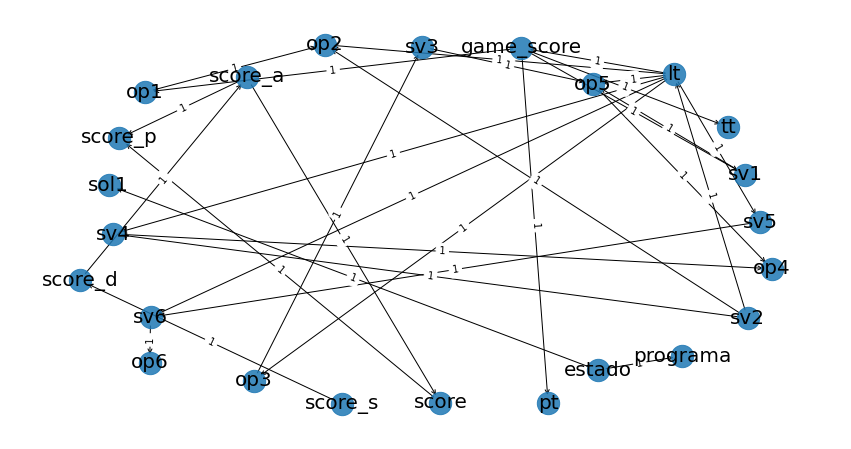

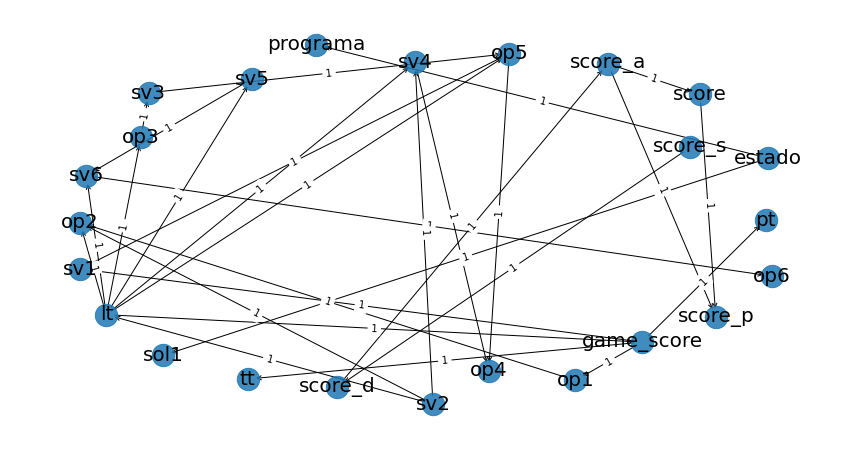

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

FILA N°: 1 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4756 |
+-----------+---------------+
| estado(1) |        0.5244 |
+-----------+---------------+
FILA N°: 2 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5630 |
+-----------+---------------+
| estado(1) |        0



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.3894 |
+-----------+---------------+
| estado(1) |        0.6106 |
+-----------+---------------+
FILA N°: 5 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4756 |
+-----------+---------------+
| estado(1) |        0.5244 |
+-----------+---------------+
FILA N°: 6 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":0.

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4756 |
+-----------+---------------+
| estado(1) |        0.5244 |
+-----------+---------------+
FILA N°: 8 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":1, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 10 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5044 |
+-----------+---------------+
| estado(1) |        0.4956 |
+-----------+---------------+
FILA N°: 11 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5276 |
+-----------+---------------+
| estado(1) |        0.4724 |
+-----------+---------------+
FILA N°: 13 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 14 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5174 |
+-----------+---------------+
| estado(1) |        0.4826 |
+-----------+---------------+
FILA N°: 15 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 17 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":3, "score_d":0, "score_s":0, "programa":3, "sol1":

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4858 |
+-----------+---------------+
| estado(1) |        0.5142 |
+-----------+---------------+
FILA N°: 18 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 19 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 22 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1":2.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5034 |
+-----------+---------------+
| estado(1) |        0.4966 |
+-----------+---------------+
FILA N°: 24 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 26 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6037 |
+-----------+---------------+
| estado(1) |        0.3963 |
+-----------+---------------+
FILA N°: 27 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 29 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 30 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5630 |
+-----------+---------------+
| estado(1) |        0.4370 |
+-----------+---------------+
FILA N°: 32 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 33 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 35 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":0, "score_d":3, "score_s":2, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5987 |
+-----------+---------------+
| estado(1) |        0.4013 |
+-----------+---------------+
FILA N°: 36 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1"








0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 39 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 40 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol1":









0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 42 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 43 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":2, "sol1"

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 45 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 46 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 47 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5276 |
+-----------+---------------+
| estado(1) |        0.4724 |
+-----------+---------------+
FILA N°: 49 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 50 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 51 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":2, "sol1":


Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5997 |
+-----------+---------------+
| estado(1) |        0.4003 |
+-----------+---------------+
FILA N°: 53 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 54 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 55 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 56 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5235 |
+-----------+---------------+
| estado(1) |        0.4765 |
+-----------+---------------+
FILA N°: 57 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 58 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5174 |
+-----------+---------------+
| estado(1) |        0.4826 |
+-----------+---------------+
FILA N°: 60 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6037 |
+-----------+---------------+
| estado(1) |        0.3963 |
+-----------+---------------+
FILA N°: 61 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":4, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 62 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 64 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 66 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 68 -> P("estado" | [{"lt":6.0, "tt":5.0, "pt":6.0, "game_score":5.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 71 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 72 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 73 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


FILA N°: 74 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 75 -> P("estado" | [{"lt":5.0, "tt":0.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |       

Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 78 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 79 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 81 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 82 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 83 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 86 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 87 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 88 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 89 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 91 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":3, "score_p":0, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 93 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 94 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":
















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:50, ?it/s]


FILA N°: 95 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 96 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 97 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":

Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 98 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 99 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [10:47, ?it/s]
Finding Elimination Order: : : 0it [10:47, ?it/s]
Finding Elimination Order: : : 0it [09:56, ?it/s]
Finding Elimination Order: : : 0it [09:15, ?it/s]
Finding Elimination Order: : : 0it [09:15, ?it/s]
Finding Elimination Order: : : 0it [09:15, ?it/s]
Finding Elimination Order: : : 0it [09:15, ?it/s]
Finding Elimination Order: : : 0it [08:24, ?it/s]
Finding Elimination Order: : : 0it [07:44, ?it/s]
Finding Elimination Order: : : 0it [06:54, ?it/s]
Finding Elimination Order: : : 0it [05:23, ?it/s]
Finding Elimination Order: : : 0it [03:52, ?it/s]
Finding Elimination Order: : : 0it [02:41, ?it/s]
Finding Elimination Order: : : 0it [01:40, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]
0it [00:00, ?it

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 101 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 102 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 103 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 104 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 105 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 107 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 108 -> P("estado" | [{"lt":4.0, "tt":3.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":2, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 110 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 111 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 112 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 114 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 115 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 117 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 118 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 119 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 122 -> P("estado" | [{"lt":4.0, "tt":4.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 124 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 125 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7134 |
+-----------+---------------+
| estado(1) |        0.2866 |
+-----------+---------------+
FILA N°: 128 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 129 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 132 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 134 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 137 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":0.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":7, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 138 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 140 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5174 |
+-----------+---------------+
| estado(1) |        0.4826 |
+-----------+---------------+
FILA N°: 144 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":0, "sv6":1, "score":1, "score_a":1, "score_p":0, "score_d":0, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 145 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 146 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 148 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":7, "score_p":1, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7326 |
+-----------+---------------+
| estado(1) |        0.2674 |
+-----------+---------------+
FILA N°: 150 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 152 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 154 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 155 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 156 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 158 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 161 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5987 |
+-----------+---------------+
| estado(1) |        0.4013 |
+-----------+---------------+
FILA N°: 162 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 163 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 165 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 167 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 169 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 171 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":1, "score_d":0, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 172 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 174 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 176 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1

0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 177 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 178 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":4, "programa":3, "sol










Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 180 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 182 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 184 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 185 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":3, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 187 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 189 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 190 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 193 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 194 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":2, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5044 |
+-----------+---------------+
| estado(1) |        0.4956 |
+-----------+---------------+
FILA N°: 195 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol













0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 198 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":5, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 199 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":1, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 201 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":2, "score_p":0, "score_d":1, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 202 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 203 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":3, "score_p":1, "score_d":3, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 204 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":1, "score_d":4, "score_s":3, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













0it [00:00, ?it/s]












Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 207 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":3, "score_s":3, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7326 |
+-----------+---------------+
| estado(1) |        0.2674 |
+-----------+---------------+
FILA N°: 208 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":5, "score_d":0, "score_s":0, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 209 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1















0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 212 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 214 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 216 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":3, "score_p":4, "score_d":3, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 217 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 218 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 222 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 223 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 224 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 225 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":1, "score_a":1, "score_p":1, "score_d":0, "score_s":0, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 228 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 230 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 231 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 233 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 234 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 235 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 236 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 237 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 240 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":0, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5174 |
+-----------+---------------+
| estado(1) |        0.4826 |
+-----------+---------------+
FILA N°: 241 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 243 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 244 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 245 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 247 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":2, "sol1":9.0}]
[bnlearn] >Variable Elimination..





















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7326 |
+-----------+---------------+
| estado(1) |        0.2674 |
+-----------+---------------+
FILA N°: 248 -> P("estado" | [{"lt":4.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":6, "score_a":2, "score_p":3, "score_d":3, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 249 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 250 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 251 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 254 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 257 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 258 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 260 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 261 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 262 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":3, "programa":2, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 263 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":5, "score_p":1, "score_d":2, "score_s":1, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 264 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...



















Finding Elimination Order: : : 0it [20:10, ?it/s]
Finding Elimination Order: : : 0it [20:00, ?it/s]
Finding Elimination Order: : : 0it [18:49, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [17:38, ?it/s]
Finding Elimination Order: : : 0it [16:37, ?it/s]
Finding Elimination Order: : : 0it [17:07, ?it/s]
Finding Elimination Order: : : 0it [16:26, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [17:16, ?it/s]
Finding Elimination Order: : : 0it [16:55, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [18:05, ?it/s]
Finding Elimination Order: : : 0it [17:45, ?it/s]



Finding Elimination Order: : : 0it [17:34, ?it/s]
Finding Elimination Order: : : 0it [16:34, ?it/s]
0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [16:03, ?it/s]
Finding Elimination Order: : : 0it [15:33, ?it/s]



Finding Elimination Order: : : 0it [14:42, ?it/s]



Finding Elimination Order: : : 0it [00:20, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 265 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 266 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 271 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 272 -> P("estado" | [{"lt":6.0, "tt":0.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 273 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 277 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 278 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 281 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 283 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 285 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 287 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":4, "sol

0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 288 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":4.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":0, "score_p":2, "score_d":1, "score_s":1, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 290 -> P("estado" | [{"lt":2.0, "tt":5.0, "pt":3.0, "game_score":4.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 292 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 294 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 295 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 298 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 299 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 300 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":6, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:30, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 302 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 303 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 304 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":5, "sol









0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:50, ?it/s]


FILA N°: 305 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 306 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 307 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":3, "score_d":4, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 308 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 309 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1











0it [00:00, ?it/s]








Finding Elimination Order: : : 0it [00:20, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 310 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 311 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 313 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 314 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]









Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 316 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":0, "score":3, "score_a":2, "score_p":0, "score_d":2, "score_s":2, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 317 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":6, "score_a":4, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 318 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]










Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 320 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 323 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":1, "score_d":1, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 324 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":1.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 327 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 329 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]











0it [00:00, ?it/s]












0it [00:00, ?it/s]











Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 332 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 333 -> P("estado" | [{"lt":5.0, "tt":1.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 334 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]












0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 337 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 338 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]













0it [00:00, ?it/s]
















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6013 |
+-----------+---------------+
| estado(1) |        0.3987 |
+-----------+---------------+
FILA N°: 339 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":7, "score_p":2, "score_d":3, "score_s":4, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 340 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1

0it [00:00, ?it/s]













Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 342 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 343 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:10, ?it/s][A


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 344 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":2, "score_d":2, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]














0it [00:00, ?it/s]















0it [00:00, ?it/s]














Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 345 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 346 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":0, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 348 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 349 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1

















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 350 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 351 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]















0it [00:00, ?it/s]
















0it [00:00, ?it/s]















Finding Elimination Order: : : 0it [00:50, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 353 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":3, "score_d":4, "score_s":4, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 355 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 356 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 358 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 362 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
















0it [00:00, ?it/s]

















0it [00:00, ?it/s]
















Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 364 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":5, "score_d":1, "score_s":1, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 365 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 366 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]




















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 368 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 370 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":1, "programa":3, "sol1

0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:30, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6013 |
+-----------+---------------+
| estado(1) |        0.3987 |
+-----------+---------------+
FILA N°: 371 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 372 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

















0it [00:00, ?it/s]


















0it [00:00, ?it/s]

















Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 376 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


















0it [00:00, ?it/s]    


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 377 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5855 |
+-----------+---------------+
| estado(1) |        0.4145 |
+-----------+---------------+
FILA N°: 378 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1




















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [01:00, ?it/s][A



















0it [00:00, ?it/s]    



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...




















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 381 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 382 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":0, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 383 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 384 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":1, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A



















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 386 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 389 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 390 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 391 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":1, "score_s":1, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 393 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "programa":4, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 394 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 395 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 397 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 398 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 399 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":3, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]



















Finding Elimination Order: : : 0it [00:50, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 401 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 402 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":1, "score_s":2, "programa":5, "sol1

 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 403 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 404 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":2, "sol1


Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...




















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 406 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 407 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 409 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":12, "score_a":8, "score_p":5, "score_d":4, "score_s":4, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 410 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















Finding Elimination Order: : : 0it [00:40, ?it/s][A


FILA N°: 412 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 413 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |   




















0it [00:00, ?it/s]    



















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 415 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":2, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5855 |
+-----------+---------------+
| estado(1) |        0.4145 |
+-----------+---------------+
FILA N°: 416 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":4.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1




















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]





















+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 417 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 418 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":2, "programa":3, "sol

 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...


















 ... (more hidden) ...


















0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]



















 ... (more hidden) ...



















Finding Elimination Order: : : 0it [32:01, ?it/s]
Finding Elimination Order: : : 0it [21:01, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [20:50, ?it/s]
Finding Elimination Order: : : 0it [21:00, ?it/s]
Finding Elimination Order: : : 0it [20:39, ?it/s]
Finding Elimination Order: : : 0it [20:09, ?it/s]


Finding Elimination Order: : : 0it [20:19, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [19:38, ?it/s]
Finding Elimination Order: : : 0it [19:08, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [19:27, ?it/s]
Finding Elimination Order: : : 0it [18:57, ?it/s]



Fin

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 420 -> P("estado" | [{"lt":3.0, "tt":3.0, "pt":4.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":0, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 421 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":3, "sol

Finding Elimination Order: : : 0it [08:10, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [06:20, ?it/s]
Finding Elimination Order: : : 0it [04:00, ?it/s]
Finding Elimination Order: : : 0it [02:00, ?it/s]
Finding Elimination Order: : : 0it [00:40, ?it/s]
0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]



+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 427 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 429 -> P("estado" | [{"lt":4.0, "tt":0.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":8, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":1, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 431 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 432 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:10, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 435 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":4, "score_d":1, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..




0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 438 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 439 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":2, "score_d":0, "score_s":1, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 440 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 441 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 443 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 444 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 447 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 449 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 450 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 451 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 453 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 455 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7326 |
+-----------+---------------+
| estado(1) |        0.2674 |
+-----------+---------------+
FILA N°: 458 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 459 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 461 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":2, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 462 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 464 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 467 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":4, "score_s":3, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
[[333   1]
 [ 33   7]]
RESULTADOS DEL ENTRENAMIENTO:
(TRAIN) Fold 5 Accuracy          : 0.9090909090909091
(TRAIN) Fold 5 Balanced Accuracy : 0.8924180327868853
(TRAIN) Fold 5 Precision Score   : 0.9794229722373434
(TRAIN) Fold 5 Recall Score      : 0.9090909090909091
(TRAIN) Fold 5 ROC AUC           : 0.5860029940119761
(TRAIN) Fold 5 Class Ratio       : 0.10695187165775401
FIN DE SECCION DE ENTRENAMIENTO, FOLD:  5
INICIO DE SECCION DE PRUEBAS, FOLD:  5
FILA N°: 4 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":0.0}]
[bnlearn] >Variable Elimination..
+-----------+---------



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4858 |
+-----------+---------------+
| estado(1) |        0.5142 |
+-----------+---------------+
FILA N°: 9 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5174 |
+-----------+---------------+
| estado(1) |        0.4826 |
+-----------+---------------+
FILA N°: 16 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":3, "sol1":5



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 21 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":2, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5044 |
+-----------+---------------+
| estado(1) |        0.4956 |
+-----------+---------------+
FILA N°: 23 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":3, "score_d":0, "score_s":1, "programa":4, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5133 |
+-----------+---------------+
| estado(1) |        0.4867 |
+-----------+---------------+
FILA N°: 31 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 38 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":4, "sol1":

Finding Elimination Order: : : 0it [00:10, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 48 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 59 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":9, "score_a":5, "score_p":4, "score_d":4, "score_s":2, "programa":4, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 63 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":3, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 67 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":3, "programa":5, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 69 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 77 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":3, "score_a":2, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1"



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5122 |
+-----------+---------------+
| estado(1) |        0.4878 |
+-----------+---------------+
FILA N°: 84 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 92 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol1":



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 113 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":2, "score_p":3, "score_d":1, "score_s":1, "programa":5, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6037 |
+-----------+---------------+
| estado(1) |        0.3963 |
+-----------+---------------+
FILA N°: 120 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":4, "score_d":1, "score_s":1, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 121 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 123 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":9, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 127 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":4, "sol1":4.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5174 |
+-----------+---------------+
| estado(1) |        0.4826 |
+-----------+---------------+
FILA N°: 130 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 131 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 133 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 136 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":4, "score_d":3, "score_s":2, "programa":3, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 139 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 141 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 142 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":2, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 147 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":5, "score_p":1, "score_d":2, "score_s":3, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 151 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":3, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 157 -> P("estado" | [{"lt":2.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":1, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5225 |
+-----------+---------------+
| estado(1) |        0.4775 |
+-----------+---------------+
FILA N°: 160 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":4, "score_d":4, "score_s":3, "programa":5, "so



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 164 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 168 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":2, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 175 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":4, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 181 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":4, "score_d":3, "score_s":3, "programa":5, "so



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 188 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":2, "score_d":4, "score_s":2, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 192 -> P("estado" | [{"lt":0.0, "tt":4.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 196 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 205 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":5.0, "game_score":4.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5133 |
+-----------+---------------+
| estado(1) |        0.4867 |
+-----------+---------------+
FILA N°: 211 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":2, "score_s":0, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 213 -> P("estado" | [{"lt":2.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":2, "score_d":2, "score_s":1, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 219 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":0, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":4, "score_a":1, "score_p":3, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 220 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":4, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":2, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5044 |
+-----------+---------------+
| estado(1) |        0.4956 |
+-----------+---------------+
FILA N°: 227 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":3, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 229 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":3, "score_a":1, "score_p":1, "score_d":2, "score_s":1, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 238 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":3, "score_p":1, "score_d":1, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 252 -> P("estado" | [{"lt":3.0, "tt":1.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":0, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 253 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 255 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":3, "score_d":2, "score_s":2, "programa":5, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6037 |
+-----------+---------------+
| estado(1) |        0.3963 |
+-----------+---------------+
FILA N°: 256 -> P("estado" | [{"lt":1.0, "tt":4.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":6, "score_a":4, "score_p":2, "score_d":2, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 259 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":5, "score_a":3, "score_p":4, "score_d":0, "score_s":1, "programa":2, "sol1

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.4258 |
+-----------+---------------+
| estado(1) |        0.5742 |
+-----------+---------------+
FILA N°: 270 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":3, "score_s":4, "programa":5, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6728 |
+-----------+---------------+
| estado(1) |        0.3272 |
+-----------+---------------+
FILA N°: 274 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":2, "programa":4, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 276 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":7, "score_a":5, "score_p":2, "score_d":3, "score_s":2, "programa":5, "sol1":5.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5987 |
+-----------+---------------+
| estado(1) |        0.4013 |
+-----------+---------------+
FILA N°: 279 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6767 |
+-----------+---------------+
| estado(1) |        0.3233 |
+-----------+---------------+
FILA N°: 282 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":3, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6013 |
+-----------+---------------+
| estado(1) |        0.3987 |
+-----------+---------------+
FILA N°: 286 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 289 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":2, "score_d":0, "score_s":0, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 291 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":3.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":3, "score_d":3, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 293 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":0, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":8, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 297 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":2, "score_d":3, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 321 -> P("estado" | [{"lt":1.0, "tt":2.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":6, "score_p":4, "score_d":2, "score_s":2, "programa":4, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 322 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":5, "score_p":3, "score_d":3, "score_s":3, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7188 |
+-----------+---------------+
| estado(1) |        0.2812 |
+-----------+---------------+
FILA N°: 325 -> P("estado" | [{"lt":3.0, "tt":0.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":0, "score":5, "score_a":1, "score_p":3, "score_d":1, "score_s":2, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 328 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":3, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 330 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":2, "programa":3, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 335 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":6, "score_a":2, "score_p":4, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 341 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":3, "score_p":4, "score_d":2, "score_s":3, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 354 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1



Finding Elimination Order: : : 0it [00:10, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 359 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":1.0, "game_score":2.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":2, "programa":2, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6425 |
+-----------+---------------+
| estado(1) |        0.3575 |
+-----------+---------------+
FILA N°: 360 -> P("estado" | [{"lt":0.0, "tt":3.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":2, "so



Finding Elimination Order: : : 0it [00:10, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7326 |
+-----------+---------------+
| estado(1) |        0.2674 |
+-----------+---------------+
FILA N°: 361 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":0, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":0, "score":8, "score_a":5, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 367 -> P("estado" | [{"lt":1.0, "tt":3.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":2, "score_a":1, "score_p":1, "score_d":0, "score_s":1, "programa":3, "sol1



Finding Elimination Order: : : 0it [00:10, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 369 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":2.0, "game_score":1.0, "op1":0, "op2":0, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":4, "score_p":5, "score_d":2, "score_s":2, "programa":5, "sol1":8.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 375 -> P("estado" | [{"lt":3.0, "tt":4.0, "pt":5.0, "game_score":4.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":0, "sv3":0, "sv4":1, "sv5":0, "sv6":0, "score":5, "score_a":4, "score_p":2, "score_d":1, "score_s":2, "programa":4, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.6677 |
+-----------+---------------+
| estado(1) |        0.3323 |
+-----------+---------------+
FILA N°: 379 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":3.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":5, "score_d":1, "score_s":1, "programa":4, "sol1":6.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.5914 |
+-----------+---------------+
| estado(1) |        0.4086 |
+-----------+---------------+
FILA N°: 387 -> P("estado" | [{"lt":0.0, "tt":2.0, "pt":2.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":3, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7270 |
+-----------+---------------+
| estado(1) |        0.2730 |
+-----------+---------------+
FILA N°: 388 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":8, "score_a":6, "score_p":2, "score_d":4, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 396 -> P("estado" | [{"lt":3.0, "tt":2.0, "pt":3.0, "game_score":3.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":0, "score":4, "score_a":2, "score_p":2, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]




+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 400 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1":7.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7406 |
+-----------+---------------+
| estado(1) |        0.2594 |
+-----------+---------------+
FILA N°: 408 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 422 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":0.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":0, "sv6":1, "score":4, "score_a":4, "score_p":1, "score_d":1, "score_s":1, "programa":4, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7958 |
+-----------+---------------+
| estado(1) |        0.2042 |
+-----------+---------------+
FILA N°: 428 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":0, "sv6":1, "score":5, "score_a":2, "score_p":3, "score_d":1, "score_s":2, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 434 -> P("estado" | [{"lt":1.0, "tt":0.0, "pt":1.0, "game_score":1.0, "op1":0, "op2":1, "op3":1, "op4":0, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":1, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 436 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":5, "score_p":3, "score_d":2, "score_s":3, "programa":5, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.7841 |
+-----------+---------------+
| estado(1) |        0.2159 |
+-----------+---------------+
FILA N°: 437 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":0.0, "game_score":0.0, "op1":0, "op2":0, "op3":0, "op4":1, "op5":0, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":11, "score_a":7, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 446 -> P("estado" | [{"lt":1.0, "tt":1.0, "pt":1.0, "game_score":1.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":4, "score_d":2, "score_s":1, "programa":5, "sol



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]


Finding Elimination Order: : : 0it [00:50, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 448 -> P("estado" | [{"lt":0.0, "tt":0.0, "pt":1.0, "game_score":0.0, "op1":0, "op2":1, "op3":0, "op4":0, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":0, "sv4":0, "sv5":1, "sv6":1, "score":10, "score_a":6, "score_p":5, "score_d":3, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 454 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":1.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":1, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":5, "score_a":4, "score_p":1, "score_d":2, "score_s":2, "programa":5, "sol



Finding Elimination Order: : : 0it [00:10, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]
Finding Elimination Order: : : 0it [00:20, ?it/s]


+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
FILA N°: 456 -> P("estado" | [{"lt":0.0, "tt":1.0, "pt":0.0, "game_score":0.0, "op1":1, "op2":1, "op3":1, "op4":1, "op5":1, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":1, "sv5":1, "sv6":1, "score":7, "score_a":4, "score_p":3, "score_d":2, "score_s":3, "programa":3, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 465 -> P("estado" | [{"lt":2.0, "tt":1.0, "pt":2.0, "game_score":2.0, "op1":0, "op2":0, "op3":1, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":1, "sv4":0, "sv5":1, "sv6":1, "score":9, "score_a":6, "score_p":3, "score_d":4, "score_s":3, "programa":3, "sol1



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:10, ?it/s]

+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8024 |
+-----------+---------------+
| estado(1) |        0.1976 |
+-----------+---------------+
FILA N°: 466 -> P("estado" | [{"lt":2.0, "tt":2.0, "pt":0.0, "game_score":2.0, "op1":1, "op2":1, "op3":0, "op4":0, "op5":0, "op6":0, "sv1":1, "sv2":1, "sv3":0, "sv4":1, "sv5":1, "sv6":0, "score":10, "score_a":7, "score_p":4, "score_d":4, "score_s":3, "programa":5, "sol1":9.0}]
[bnlearn] >Variable Elimination..
+-----------+---------------+
| estado    |   phi(estado) |
+===========+===============+
| estado(0) |        0.8470 |
+-----------+---------------+
| estado(1) |        0.1530 |
+-----------+---------------+
[[83  1]
 [ 8  1]]
RESULTADOS DEL ENTRENAMIENTO:
(TEST) Fold 5 Accuracy          : 0.9032258064516129
(TEST) Fold 5 Balanced Accuracy : 0.706043956043956
(TEST) Fold 5 Precision Score   : 0.9692353643966548
(TEST) Fold 5 Recall Score      : 0.9032258064516129
(TEST) F


Finding Elimination Order: : : 0it [00:20, ?it/s]


In [7]:
if flagModelo == 0:
    modelos.modeloPython (df, varClase, 5, scorePython, balanceado, seleccionVariables)
    
if flagModelo == 1:   
    modelos.modeloR(df, varClase, 5, discreta, scoreR, balanceado, seleccionVariables)